# Income Classification

1. [Daten laden und Dataframe erzeugen](#data)
2. [Deskriptive Statistik](#descriptive)
3. [Visualisierung und Daten aufbereiten](#visual)
4. [Kodierung & Skalierung der Daten](#scale)
5. [PCA](#pca)
6. [Clustering](#clustering)
7. [Modelle](#models)
    * [Logit mit original Daten](#logit)
    * [Logit mit PCA](#logit-pca)
    * [Logit mit nicht lineaer transformierten Daten](#logit-transformed)
    * [Random Forest](#random-forest)
    * [Random Forest tuned](#random-forest-tuned)
    * [Random Forest mit PCA](#random-forest-pca)
    * [Neuronales Netz](#neuronal)
    * [Neuronales Netz mit PCA](#neuronal-pca)
8. [Vergleich der Modelle](#compare)

## Offene Todos
- neuronales Netz speichern und laden
- Sensitivität und  von confusion matrix
- Notebook dokumentieren

#### Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.ticker as mtick
import numpy as np
import category_encoders as ce
import tensorflow as tf
from matplotlib.patches import Patch
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score
import statsmodels
from statsmodels.discrete.discrete_model import Logit 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from itertools import combinations
from sklearn.cluster import KMeans
import keras_tuner
import keras
import matplotlib.ticker as mticker
import math
from sklearn.tree import plot_tree

## Daten laden und Dataframe erzeugen <a class="data" id="data"></a>

In [2]:
train_df = pd.read_csv('adult.data', delimiter=',', skipinitialspace=True, na_values=['?'])
test_df = pd.read_csv('adult.test', delimiter=',', skipinitialspace=True, na_values=['?'])
df = pd.concat([train_df, test_df])
df.reset_index(drop=True, inplace=True)
df.index = range(0, len(df))
df_size = df.shape[0]

print(f'Dataset Size: {df_size}')

Dataset Size: 48842


Wir verändern die Zielgröße und verwenden **1** für die Klasse **>50k** und **0** für die Klasse **<=50k**. Es fäält auf, dass **education-num** bereits die Variable **education** als numerische Werte abbildet, alleridngs von 0 bis 16. Das ist unbrauchbar.

In [3]:
df['income'] = df['income'].apply(lambda x: 1 if x == '>50K' else 0)
df = df.drop('education-num', axis= 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       46043 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   marital-status  48842 non-null  object
 5   occupation      46033 non-null  object
 6   relationship    48842 non-null  object
 7   race            48842 non-null  object
 8   sex             48842 non-null  object
 9   capital-gain    48842 non-null  int64 
 10  capital-loss    48842 non-null  int64 
 11  hours-per-week  48842 non-null  int64 
 12  native-country  47985 non-null  object
 13  income          48842 non-null  int64 
dtypes: int64(6), object(8)
memory usage: 5.2+ MB


Der Datensatz enthält einige **NaN** Werte. Diese ersetzen wir durch die jeweils am häufigsten vorkommenden Werte der jeweiligen Input-Variable.

In [4]:
df.isnull().sum()

age                  0
workclass         2799
fnlwgt               0
education            0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     857
income               0
dtype: int64

In [5]:
df['workclass'].fillna(df['workclass'].mode()[0], inplace=True)
df['occupation'].fillna(df['occupation'].mode()[0], inplace=True)
df['native-country'].fillna(df['native-country'].mode()[0], inplace=True)   

df['workclass'].fillna(df['workclass'].mode()[0], inplace=True)
df['occupation'].fillna(df['occupation'].mode()[0], inplace=True)
df['native-country'].fillna(df['native-country'].mode()[0], inplace=True)

df.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

## Deskriptive Statistik <a class="descriptive" id="descriptive"></a>

### Numerische Variablen

In [6]:
numeric = [var for var in df.columns if df[var].dtype!=object]
numeric.remove("income")
print('\nThere are {} numeric variables:\n\n{}'.format(len(numeric), numeric))

df.describe().T


There are 5 numeric variables:

['age', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week']


count           mean            std      min       25%  \
age             48842.0      38.643585      13.710510     17.0      28.0   
fnlwgt          48842.0  189664.134597  105604.025423  12285.0  117550.5   
capital-gain    48842.0    1079.067626    7452.019058      0.0       0.0   
capital-loss    48842.0      87.502314     403.004552      0.0       0.0   
hours-per-week  48842.0      40.422382      12.391444      1.0      40.0   
income          48842.0       0.239282       0.426649      0.0       0.0   

                     50%       75%        max  
age                 37.0      48.0       90.0  
fnlwgt          178144.5  237642.0  1490400.0  
capital-gain         0.0       0.0    99999.0  
capital-loss         0.0       0.0     4356.0  
hours-per-week      40.0      45.0       99.0  
income               0.0       0.0        1.0

### Kategoriale Variablen

In [7]:
categorical = [var for var in df.columns if df[var].dtype==object]


print('There are {} categorical variables:\n'.format(len(categorical)))

for var in categorical:

    print(f'{var} contains {len(df[var].unique())} labels')

There are 8 categorical variables:

workclass contains 8 labels
education contains 16 labels
marital-status contains 7 labels
occupation contains 14 labels
relationship contains 6 labels
race contains 5 labels
sex contains 2 labels
native-country contains 41 labels


## Visualisierung und Daten aufbereiten <a class="visual" id="visual"></a>

Bevor wir die Daten weiter bearbeiten, schauen wir uns zunächst einmal verschiedene Visualisierungen dazu an, um entscheiden zu können, was wir mit den Daten machen:

### Verteilung von **income**

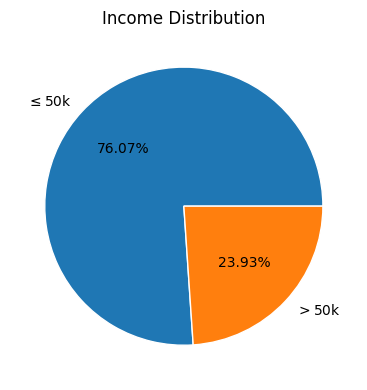

In [9]:
plt.figure(figsize=(4,4))
df['income'].value_counts().plot.pie(labels=[r'$\leq50$k', r'$>50$k'], autopct='%1.2f%%', wedgeprops = {"linewidth": 1, "edgecolor": "white"})
plt.title('Income Distribution')
plt.tight_layout()
plt.ylabel('')
plt.savefig('figs-sampled/income_distribution.png')
plt.show()

### Resampling

In [10]:
df_0 = df[df['income'] == 0]
df_1 = df[df['income'] == 1]

df_1_resampled = df_1.sample(n=len(df_0), replace=True, random_state=42)

balanced_df = pd.concat([df_0, df_1_resampled])

df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

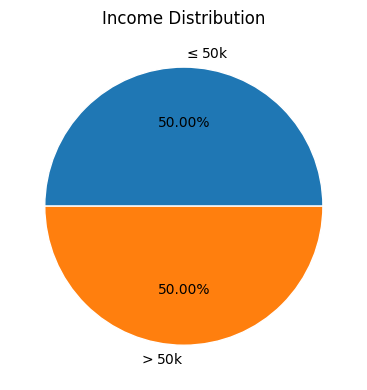

In [11]:
plt.figure(figsize=(4,4))
df['income'].value_counts().plot.pie(labels=[r'$\leq50$k', r'$>50$k'], autopct='%1.2f%%', wedgeprops = {"linewidth": 1, "edgecolor": "white"})
plt.title('Income Distribution')
plt.tight_layout()
plt.ylabel('')
plt.savefig('figs-sampled/income_distribution_resampled.png')
plt.show()

### Korrelationsmatrix der numerischen Variablen

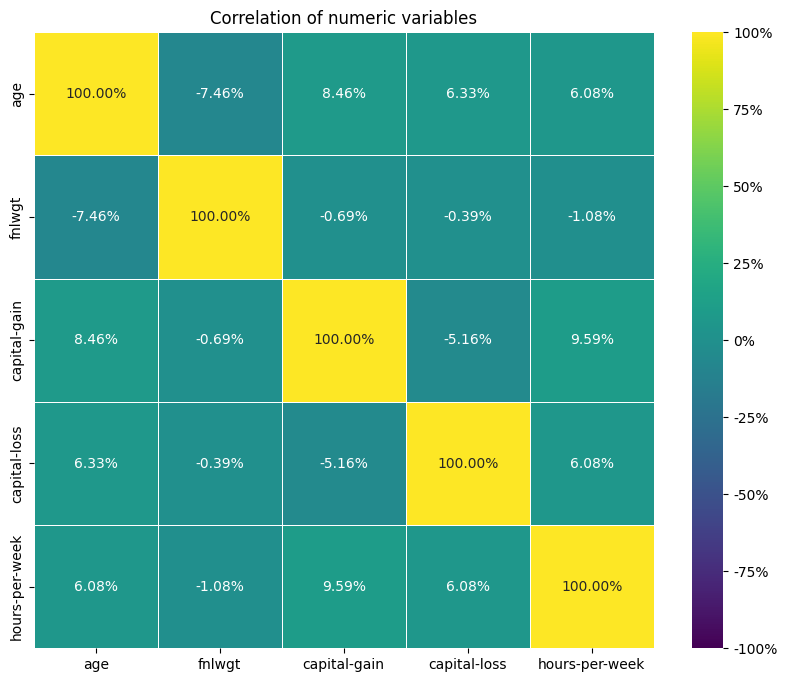

In [12]:
plt.figure(figsize=(10,8), dpi=100)
sns.heatmap(df[numeric].corr(), cmap="viridis", fmt=".2%",linewidth=0.5, annot=True, vmin=-1, vmax=1)
formatter = mticker.FuncFormatter(lambda x, _: f"{x*100:.0f}%")
cax = plt.gcf().axes[-1]
cax.yaxis.set_major_formatter(formatter)
plt.title("Correlation of numeric variables")
plt.savefig('figs-sampled/correlation.png')
plt.show()

### Numerische Variablen bezogen auf **income**

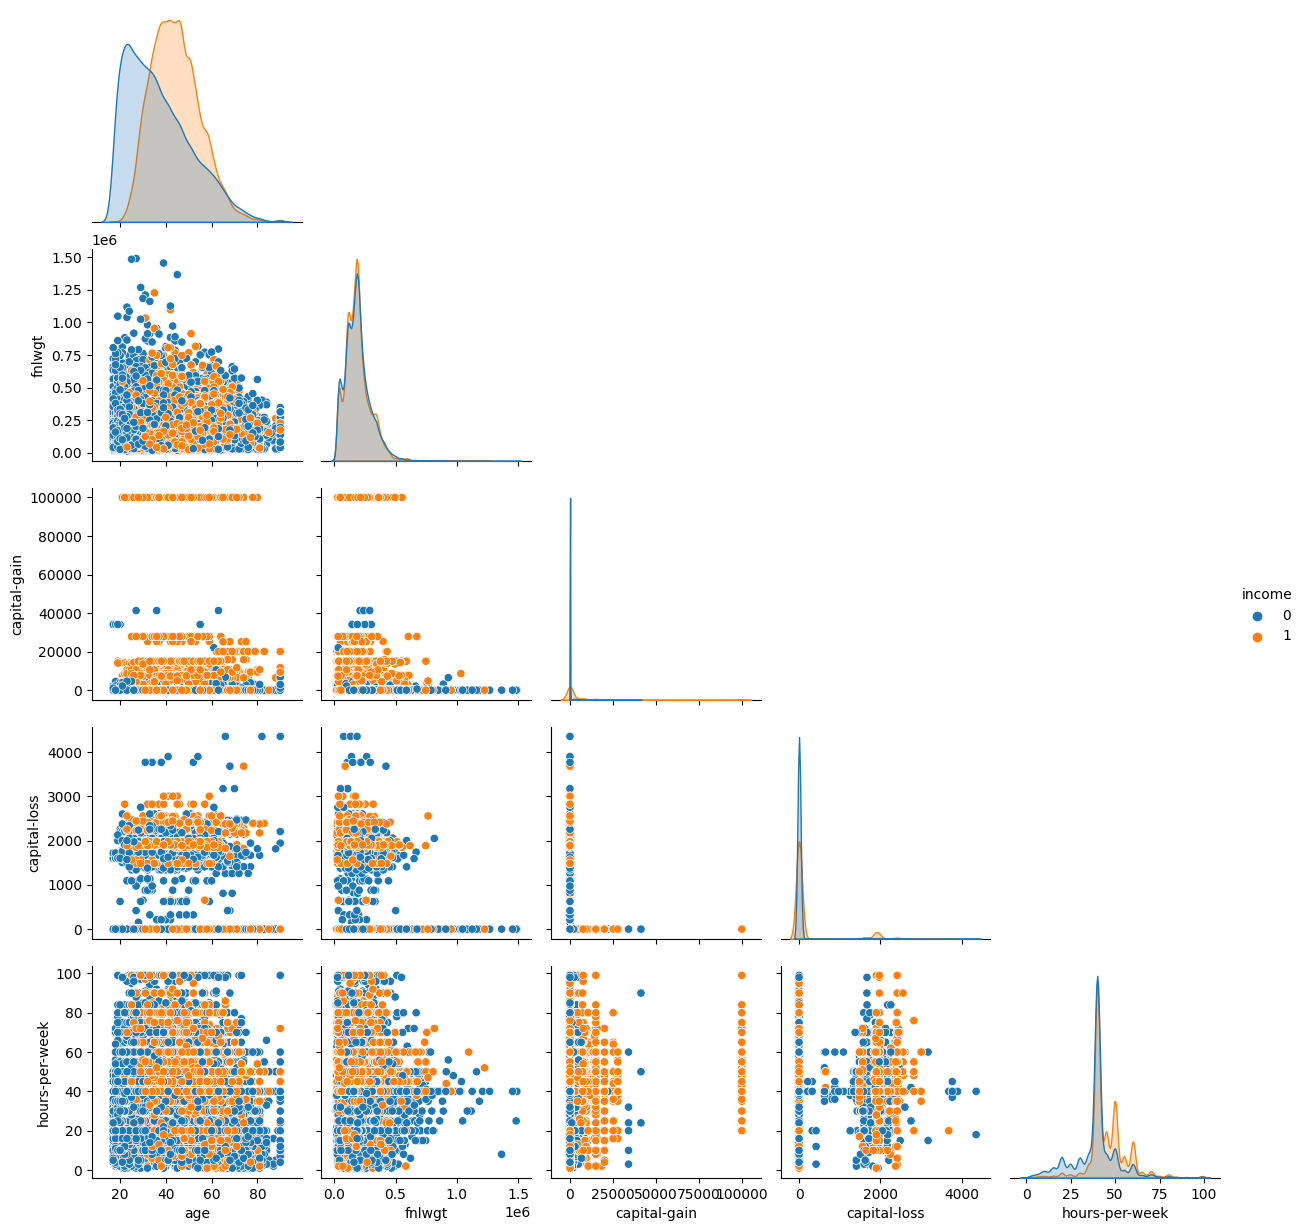

In [13]:
sns.pairplot(df.drop(categorical, axis=1), hue='income', corner=True)
plt.savefig('figs-sampled/pair_plot.png')
plt.show()

### Histogramm und Boxplots der numerischen Variablen

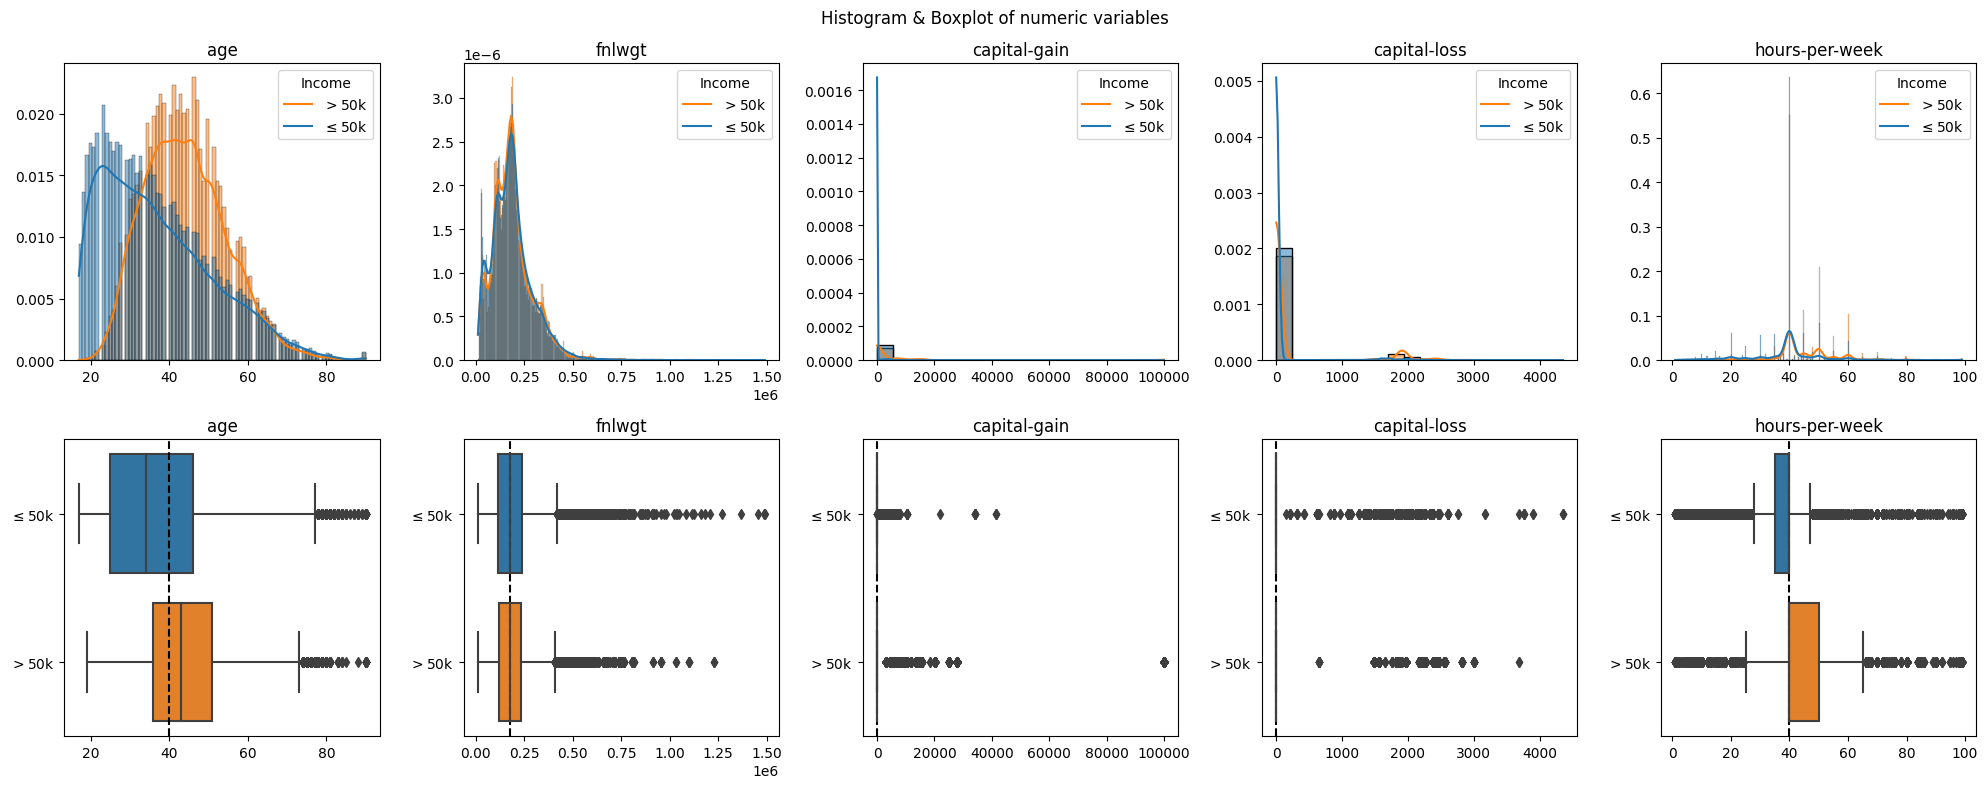

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=len(numeric), figsize=(20, 8))
fig.suptitle("Histogram & Boxplot of numeric variables")

for i, variable in enumerate(numeric):
    sns.histplot(data=df, x=variable, hue='income', ax=axes[0][i], kde=True, stat='density')
    sns.boxplot(data=df, x=variable, y='income', ax=axes[1][i], orient='h')

    axes[0][i].set_xlabel(None)
    axes[0][i].set_ylabel(None)
    axes[0][i].set_title(variable)
    axes[0][i].legend(title='Income', labels=['$>50$k', '$\leq50$k'])

    axes[1][i].set_xlabel(None)
    axes[1][i].set_ylabel(None)
    axes[1][i].set_title(variable)
    axes[1][i].set_yticklabels(['$\leq50$k', '$>50$k'])

    median = df[variable].median()
    axes[1][i].axvline(median, linestyle='--', color='black')
    
plt.tight_layout()
plt.savefig('figs-sampled/histogram_boxplot.png')
plt.show()

### Ausreißer behandeln

Wir transformieren **capital-gain** und **capital-loss** als bninäre Features.

In [15]:
df['capital-gain'] = np.where(df['capital-gain'] == 0, 0, 1)
df['capital-loss'] = np.where(df['capital-loss'] == 0, 0, 1)

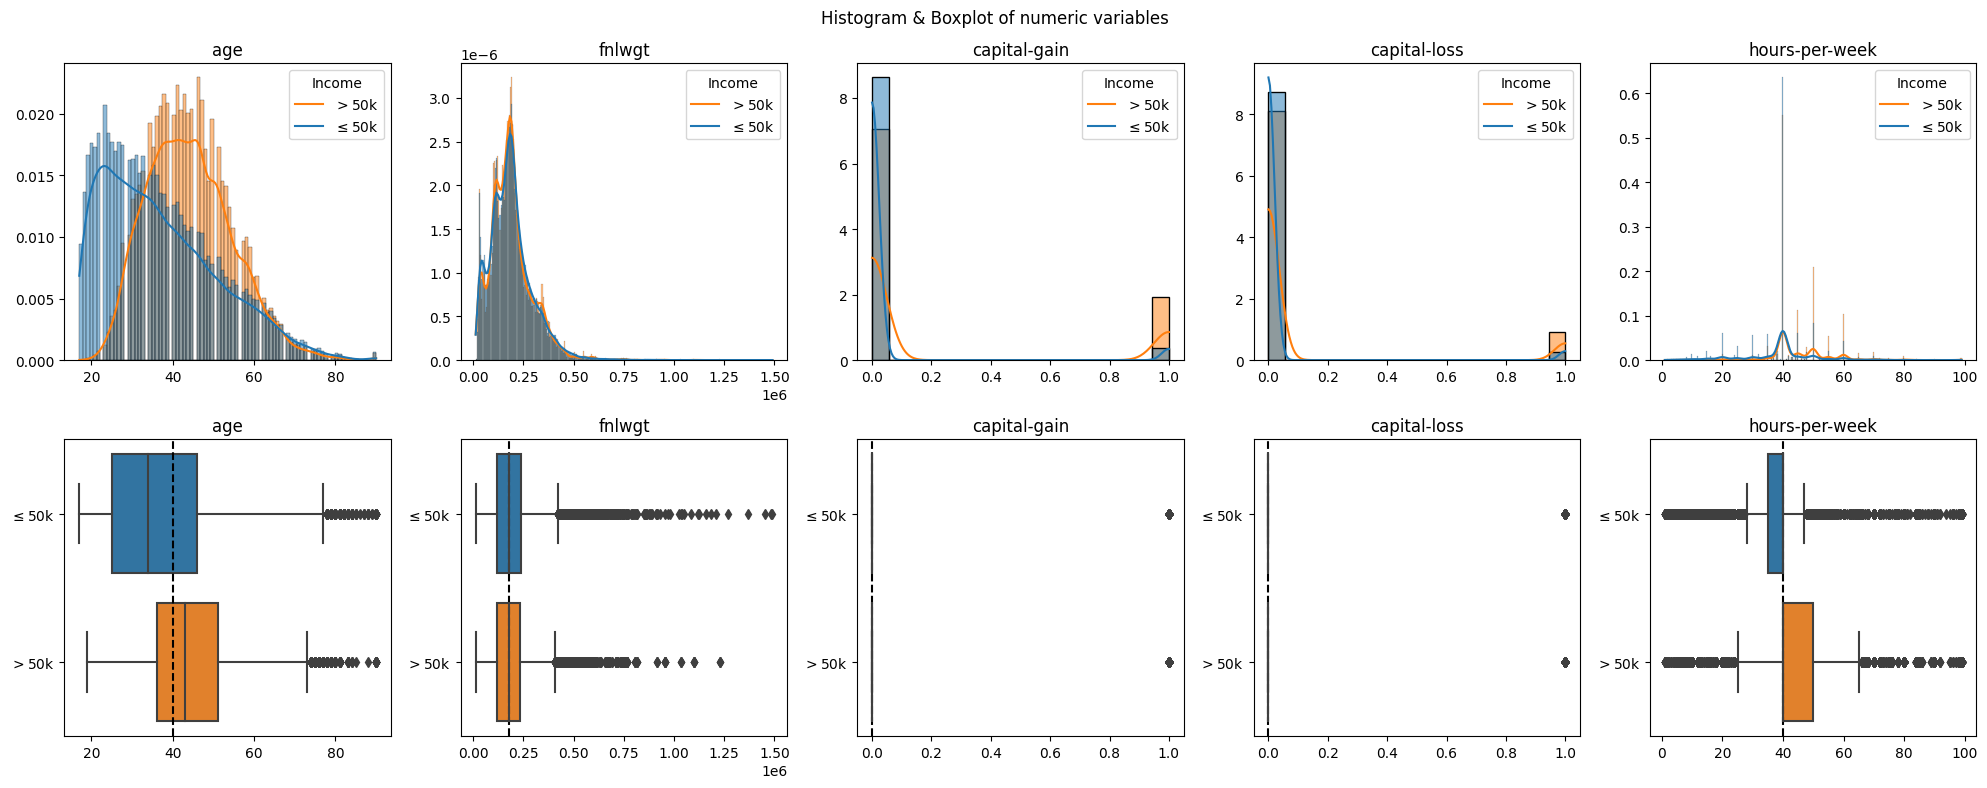

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=len(numeric), figsize=(20, 8))
fig.suptitle("Histogram & Boxplot of numeric variables")


for i, variable in enumerate(numeric):
    sns.histplot(data=df, x=variable, hue='income', ax=axes[0][i], kde=True, stat='density')
    sns.boxplot(data=df, x=variable, y='income', ax=axes[1][i], orient='h')

    axes[0][i].set_xlabel(None)
    axes[0][i].set_ylabel(None)
    axes[0][i].set_title(variable)
    axes[0][i].legend(title='Income', labels=['$>50$k', '$\leq50$k'])

    axes[1][i].set_xlabel(None)
    axes[1][i].set_ylabel(None)
    axes[1][i].set_title(variable)
    axes[1][i].set_yticklabels(['$\leq50$k', '$>50$k'])

    median = df[variable].median()
    axes[1][i].axvline(median, linestyle='--', color='black')
    
plt.tight_layout()
plt.savefig('figs-sampled/histogram_boxplot_modified.png')
plt.show()

### Verteilung der kategorialen Variablen

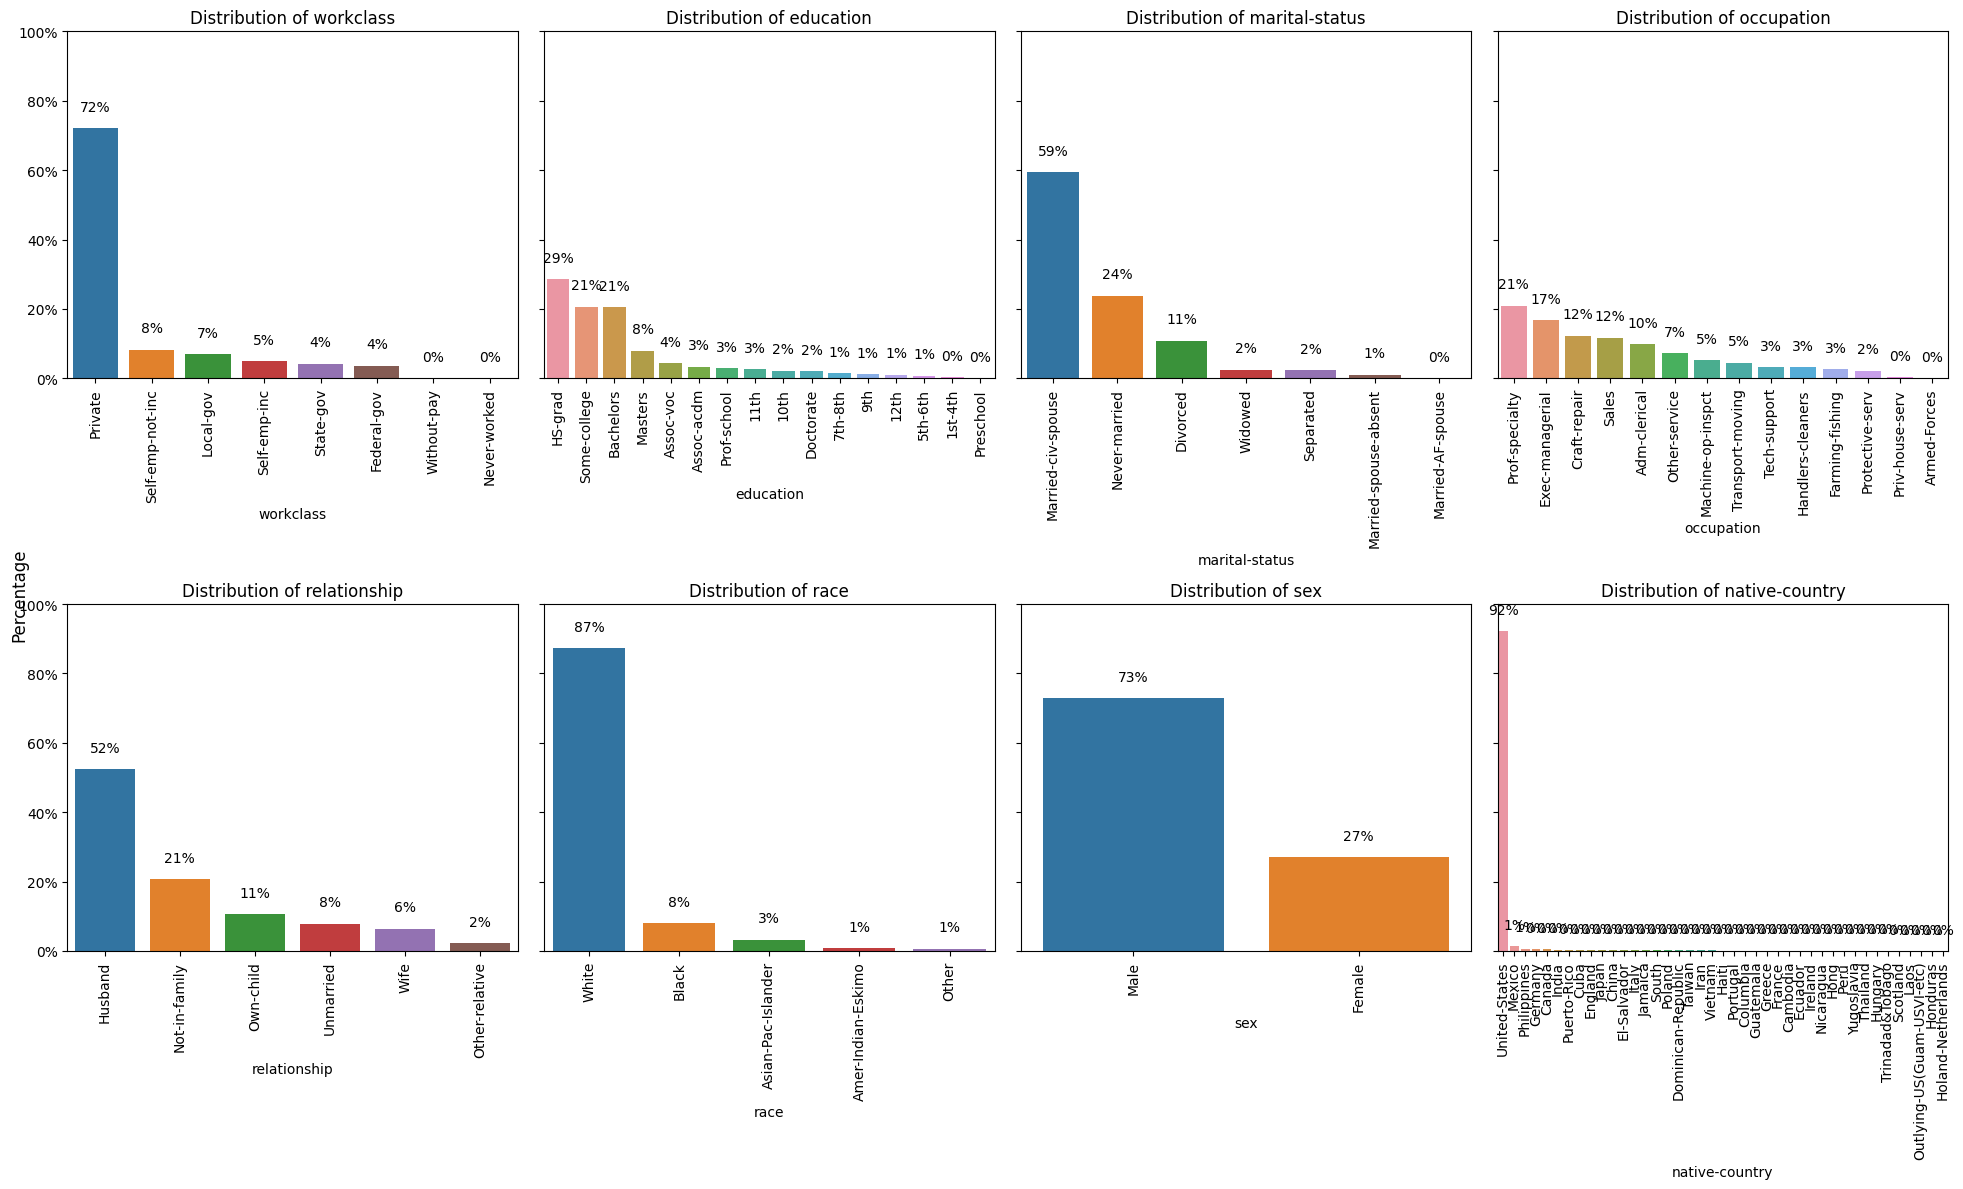

In [17]:
rows=2
cols=4

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(5*cols, 6*rows), sharey=True)
fig.supylabel('Percentage')

for i, variable in enumerate(categorical):
    row = i // cols
    col = i % cols
    ax = axes[row][col]
    pct_counts = df[variable].value_counts(normalize=True)
    sns.barplot(x=pct_counts.index, y=pct_counts.values, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    yticks = mtick.PercentFormatter(1)
    ax.yaxis.set_major_formatter(yticks)
    ax.set_ylim([0, 1])
    ax.set_title('Distribution of {}'.format(variable))

    for j, p in enumerate(ax.patches):
        ax.text(p.get_x() + p.get_width() / 2, p.get_height() + 0.05, '{:.0%}'.format(pct_counts.values[j]), ha='center')

plt.tight_layout()
plt.savefig('figs-sampled/distribution_categorical.png')
plt.show()

### Verteilung der kategorialen Variablen bezogen auf **income**

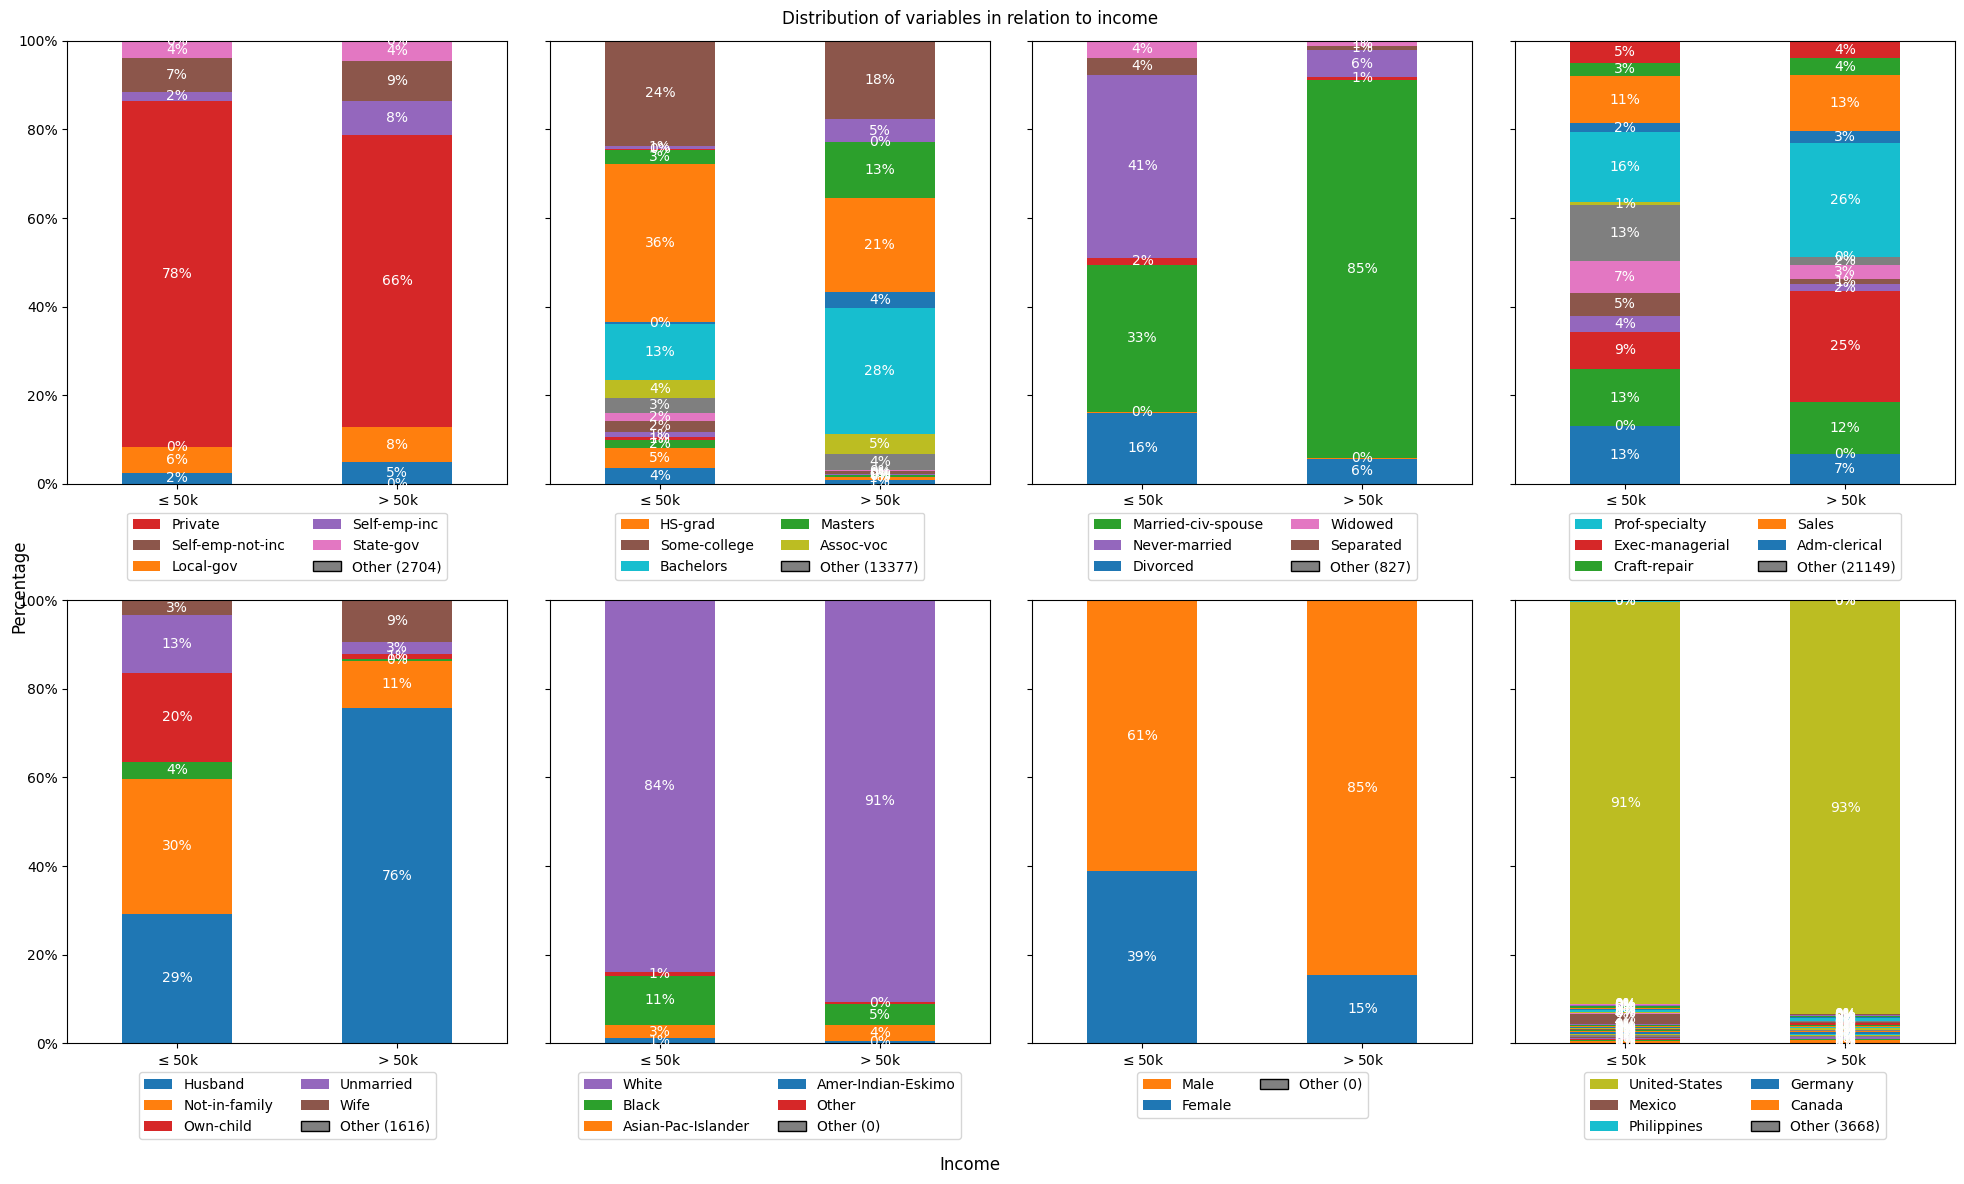

In [18]:
rows=2
cols=4

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(5*cols, 6*rows), sharey=True)
fig.suptitle('Distribution of variables in relation to income')
fig.supxlabel('Income')
fig.supylabel('Percentage')

for i, variable in enumerate(categorical):
    row = i // cols
    col = i % cols
    ax = axes[row][col]
    
    ct = pd.crosstab(df['income'], df[variable])
    ct_pct = ct.apply(lambda r: r/r.sum(), axis=1)

    ct_pct.plot(kind='bar', stacked=True, ax=ax)
    
    ax.set_xticklabels([r'$\leq50$k', r'$>50$k'], rotation=0)
    yticks = mtick.PercentFormatter(1)
    ax.yaxis.set_major_formatter(yticks)
    ax.set_ylim([0, 1])
    ax.set_xlabel('')

    handles, labels = ax.get_legend_handles_labels()
    sorted_labels = sorted(labels, key=lambda x: -ct[x].sum())
    top_labels = sorted_labels[:5]
    remaining_labels = sorted_labels[5:]
    top_handles = [handles[labels.index(l)] for l in top_labels]
    remaining_sum = sum([ct[x].sum() for x in remaining_labels])
    top_labels.append(f'Other ({remaining_sum})')
    top_handles.append(Patch(facecolor='gray', edgecolor='black'))
    ax.legend(top_handles, top_labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)


    for i in ax.containers:
        ax.bar_label(i, label_type='center', color="white", fontsize=10, fmt='{:.0%}')

plt.tight_layout()
plt.savefig('figs-sampled/distribution_categroical_hue_income.png')
plt.show()

Nun schauen wir, wie die Klassen **0** und **1** innerhalb der kategorialen Variablen verteilt sind:

### Race

In [19]:
race_counts = df.groupby('race')['income'].value_counts().unstack()
print(race_counts)

df = df.drop('race',axis= 1)
categorical.remove('race')

income                  0      1
race                            
Amer-Indian-Eskimo    415    176
Asian-Pac-Islander   1110   1315
Black                4119   1801
Other                 356    137
White               31155  33726


### Occupation

In [20]:
occupation_counts = df.groupby('occupation')['income'].value_counts().unstack()
print(occupation_counts)

income                0     1
occupation                   
Adm-clerical       4843  2480
Armed-Forces         10    16
Craft-repair       4729  4382
Exec-managerial    3178  9274
Farming-fishing    1317   568
Handlers-cleaners  1934   424
Machine-op-inspct  2650  1171
Other-service      4719   674
Priv-house-serv     239     8
Prof-specialty     5932  9621
Protective-serv     675   972
Sales              4029  4693
Tech-support       1026  1400
Transport-moving   1874  1472


In [21]:
old_labels = ["Adm-clerical", "Armed-Forces", "Craft-repair", "Farming-fishing", "Handlers-cleaners", "Machine-op-inspct", "Priv-house-serv", "Protective-serv", "Transport-moving"]
new_label = "blue" # handwerk

df.loc[df["occupation"].isin(old_labels), "occupation"] = new_label

old_labels = ["Exec-managerial", "Other-service", "Prof-specialty", "Sales", "Tech-support"]
new_label = "white" # büro

df.loc[df["occupation"].isin(old_labels), "occupation"] = new_label
occupation_counts = df.groupby('occupation')['income'].value_counts().unstack()
print(occupation_counts)

income          0      1
occupation              
blue        18271  11493
white       18884  25662


### Education

In [22]:
education_counts = df.groupby('education')['income'].value_counts().unstack().fillna(0)
print(education_counts)

income            0      1
education                 
10th           1302    292
11th           1720    273
12th            609    149
1st-4th         239     30
5th-6th         482     99
7th-8th         893    171
9th             715    118
Assoc-acdm     1188   1336
Assoc-voc      1539   1698
Bachelors      4712  10548
Doctorate       163   1329
HS-grad       13281   7900
Masters        1198   4691
Preschool        82      2
Prof-school     217   1968
Some-college   8815   6551


In [23]:
old_labels = ["Preschool", "1st-4th", "5th-6th", "7th-8th", "9th", "10th", "11th", "12th"]
new_label = "Pre-Highschool"

df.loc[df["education"].isin(old_labels), "education"] = new_label

old_labels = ["Bachelors", "Masters", "Doctorate", "Assoc-acdm", "Assoc-voc", "Prof-school", "Some-college"]
new_label = "Academic"

df.loc[df["education"].isin(old_labels), "education"] = new_label

education_counts = df.groupby('education')['income'].value_counts().unstack().fillna(0)
print(education_counts)

income              0      1
education                   
Academic        17832  28121
HS-grad         13281   7900
Pre-Highschool   6042   1134


### Workclass

In [24]:
workclass_counts = df.groupby('workclass')['income'].value_counts().unstack().fillna(0)
print(workclass_counts)

income                  0        1
workclass                         
Federal-gov         871.0   1796.0
Local-gov          2209.0   2918.0
Never-worked         10.0      0.0
Private           29053.0  24554.0
Self-emp-inc        757.0   2862.0
Self-emp-not-inc   2785.0   3371.0
State-gov          1451.0   1646.0
Without-pay          19.0      8.0


In [25]:
df = df.drop(df[df['workclass'] == 'Never-worked'].index)
df = df.drop(df[df['workclass'] == 'Without-pay'].index)


old_labels = ["Federal-gov", "Local-gov", "State-gov"]
new_label = "Gov"

df.loc[df["workclass"].isin(old_labels), "workclass"] = new_label

workclass_counts = df.groupby('workclass')['income'].value_counts().unstack().fillna(0)
print(workclass_counts)

income                0      1
workclass                     
Gov                4531   6360
Private           29053  24554
Self-emp-inc        757   2862
Self-emp-not-inc   2785   3371


### Relationship

In [26]:
relationship_counts = df.groupby('relationship')['income'].value_counts().unstack().fillna(0)
print(relationship_counts)

income              0      1
relationship                
Husband         10863  28095
Not-in-family   11306   4010
Other-relative   1453    162
Own-child        7456    363
Unmarried        4814   1012
Wife             1234   3505


In [27]:
old_labels = ["Husband", "Wife"]
new_label = "Married"

df.loc[df["relationship"].isin(old_labels), "relationship"] = new_label

relationship_counts = df.groupby('relationship')['income'].value_counts().unstack().fillna(0)
print(relationship_counts)

income              0      1
relationship                
Married         12097  31600
Not-in-family   11306   4010
Other-relative   1453    162
Own-child        7456    363
Unmarried        4814   1012


### Sex

In [28]:
sex_counts = df.groupby('sex')['income'].value_counts().unstack().fillna(0)
print(sex_counts)

income      0      1
sex                 
Female  14414   5702
Male    22712  31445


### Martial Status

In [29]:
marital_counts = df.groupby('marital-status')['income'].value_counts().unstack().fillna(0)
print(marital_counts)

df = df.drop('marital-status', axis= 1)
categorical.remove('marital-status')

income                     0      1
marital-status                     
Divorced                5961   2102
Married-AF-spouse         23     45
Married-civ-spouse     12383  31755
Married-spouse-absent    568    189
Never-married          15371   2319
Separated               1431    300
Widowed                 1389    437


### Native Country

In [30]:
native_country_counts = df.groupby('native-country')['income'].value_counts().unstack().fillna(0)
print(native_country_counts)

df = df.drop('native-country',axis= 1)
categorical.remove('native-country')

income                            0        1
native-country                              
Cambodia                       19.0     43.0
Canada                        119.0    201.0
China                          86.0    105.0
Columbia                       81.0     12.0
Cuba                          104.0    118.0
Dominican-Republic             98.0     15.0
Ecuador                        39.0     20.0
El-Salvador                   144.0     40.0
England                        80.0    139.0
France                         22.0     48.0
Germany                       148.0    178.0
Greece                         31.0     52.0
Guatemala                      85.0      6.0
Haiti                          66.0     35.0
Holand-Netherlands              1.0      0.0
Honduras                       18.0      5.0
Hong                           22.0     30.0
Hungary                        13.0     26.0
India                          89.0    194.0
Iran                           37.0     72.0
Ireland   

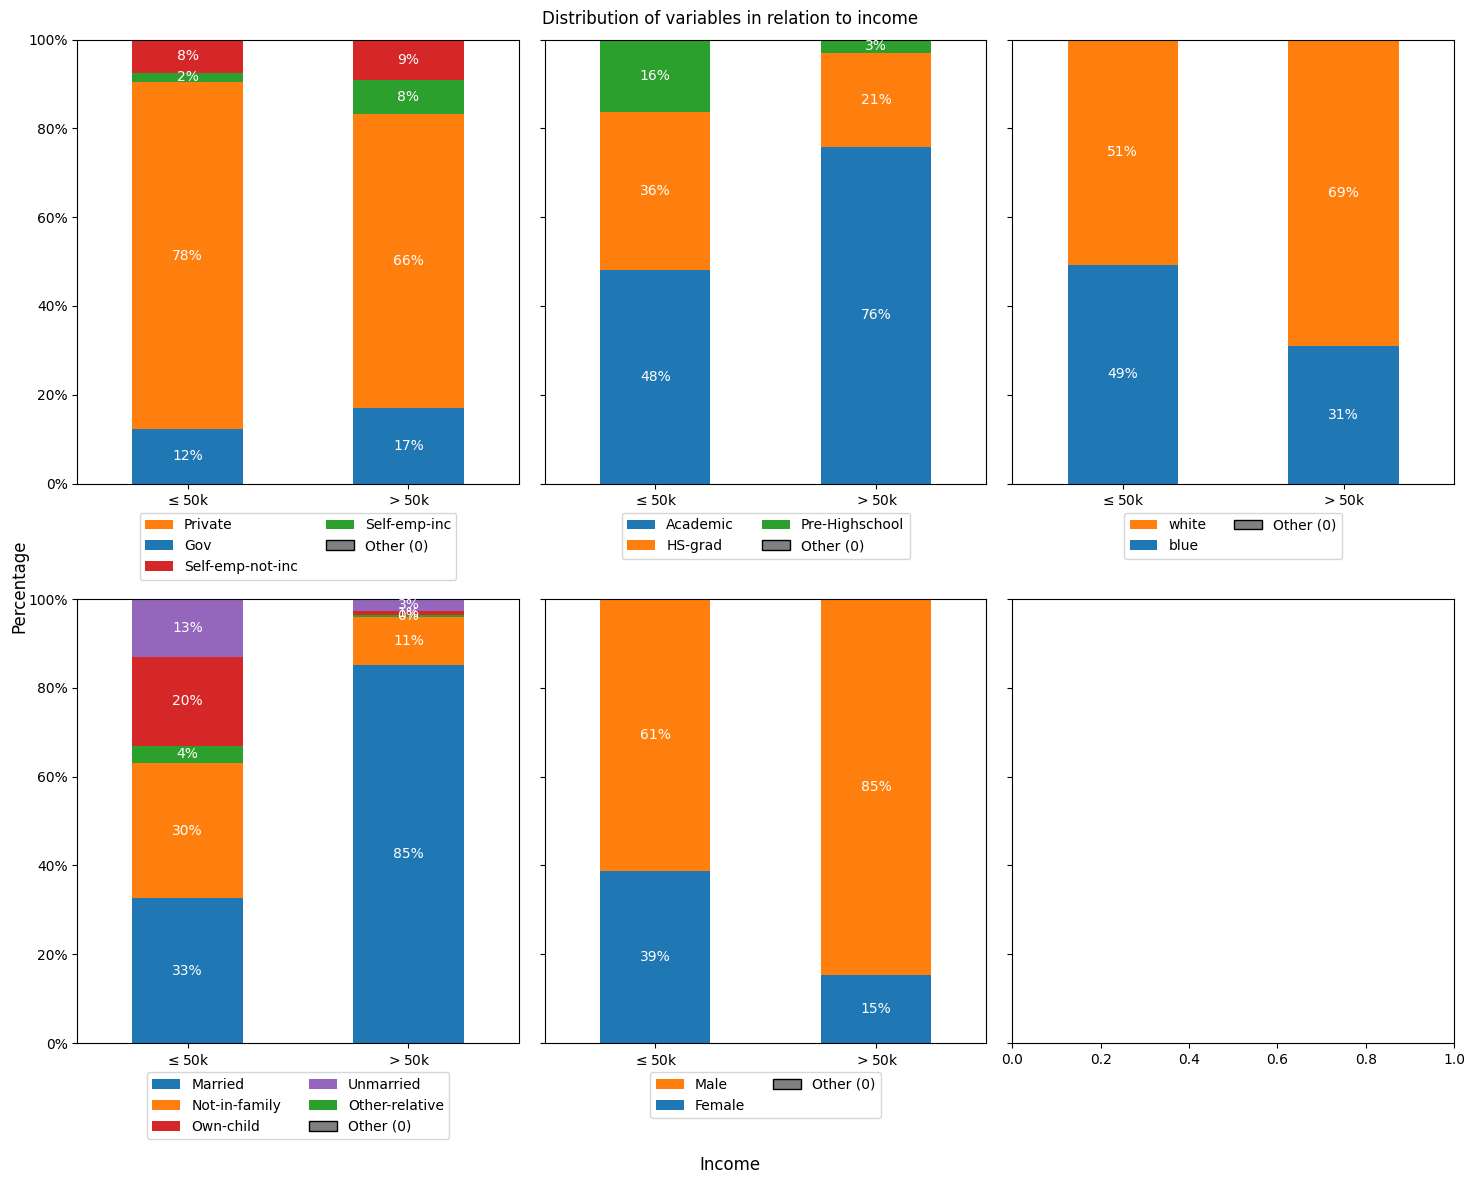

In [31]:
rows=2
cols=3

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(5*cols, 6*rows), sharey=True)
fig.suptitle('Distribution of variables in relation to income')
fig.supxlabel('Income')
fig.supylabel('Percentage')

for i, variable in enumerate(categorical):
    row = i // cols
    col = i % cols
    ax = axes[row][col]
    
    ct = pd.crosstab(df['income'], df[variable])
    ct_pct = ct.apply(lambda r: r/r.sum(), axis=1)

    ct_pct.plot(kind='bar', stacked=True, ax=ax)
    
    ax.set_xticklabels([r'$\leq50$k', r'$>50$k'], rotation=0)
    yticks = mtick.PercentFormatter(1)
    ax.yaxis.set_major_formatter(yticks)
    ax.set_ylim([0, 1])
    ax.set_xlabel('')

    handles, labels = ax.get_legend_handles_labels()
    sorted_labels = sorted(labels, key=lambda x: -ct[x].sum())
    top_labels = sorted_labels[:5]
    remaining_labels = sorted_labels[5:]
    top_handles = [handles[labels.index(l)] for l in top_labels]
    remaining_sum = sum([ct[x].sum() for x in remaining_labels])
    top_labels.append(f'Other ({remaining_sum})')
    top_handles.append(Patch(facecolor='gray', edgecolor='black'))
    ax.legend(top_handles, top_labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)


    for i in ax.containers:
        ax.bar_label(i, label_type='center', color="white", fontsize=10, fmt='{:.0%}')

plt.tight_layout()
plt.savefig('figs-sampled/distribution_categroical_hue_income_modified.png')
plt.show()

## Kodierung & Skalierung der Daten <a class="scale" id="scale"></a>

### OneHot Codierung der kategorialen Variablen

In [32]:
print(f'Dataframe Shape before encoding: {df.shape}')

onehot_encoder = ce.OneHotEncoder(cols=categorical)
df = onehot_encoder.fit_transform(df)

df = df.drop(["workclass_4", "education_3", "occupation_2", "relationship_5", "sex_2"], axis=1)

print(f'Dataframe Shape after encoding: {df.shape}')

df.head()

Dataframe Shape before encoding: (74273, 11)
Dataframe Shape after encoding: (74273, 17)


age  workclass_1  workclass_2  workclass_3  fnlwgt  education_1  \
0   31            1            0            0  228446            1   
1   29            0            1            0  201022            1   
2   20            0            1            0  188409            1   
3   30            0            1            0  144064            0   
4   53            0            1            0  149650            0   

   education_2  occupation_1  relationship_1  relationship_2  relationship_3  \
0            0             1               1               0               0   
1            0             0               0               1               0   
2            0             1               1               0               0   
3            1             0               0               1               0   
4            1             0               1               0               0   

   relationship_4  sex_1  capital-gain  capital-loss  hours-per-week  income  
0               0      1             0             0              40       0  
1               0      0             0             0              50       1  
2               0      1             0             0              60       0  
3               0      1             0             0              62       0  
4               0      1             0             1              48       1

### Skalierung der Daten

In [33]:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

### Finale Datensätze

Datensatz 1 (aufbereitet und one-hot codiert)

In [34]:
x_train, x_test, y_train, y_test = train_test_split(df.drop("income", axis=1), df["income"], test_size=0.2, shuffle=False)
df.head()

age  workclass_1  workclass_2  workclass_3  fnlwgt  education_1  \
0   31            1            0            0  228446            1   
1   29            0            1            0  201022            1   
2   20            0            1            0  188409            1   
3   30            0            1            0  144064            0   
4   53            0            1            0  149650            0   

   education_2  occupation_1  relationship_1  relationship_2  relationship_3  \
0            0             1               1               0               0   
1            0             0               0               1               0   
2            0             1               1               0               0   
3            1             0               0               1               0   
4            1             0               1               0               0   

   relationship_4  sex_1  capital-gain  capital-loss  hours-per-week  income  
0               0      1             0             0              40       0  
1               0      0             0             0              50       1  
2               0      1             0             0              60       0  
3               0      1             0             0              62       0  
4               0      1             0             1              48       1

Datensatz 2 (aufbereitet, one-hot codiert & min-max skaliert)

In [35]:
x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled = train_test_split(df_scaled.drop("income", axis=1), df_scaled["income"], test_size=0.2, shuffle=False)
df_scaled.head()

age  workclass_1  workclass_2  workclass_3    fnlwgt  education_1  \
0  0.191781          1.0          0.0          0.0  0.146241          1.0   
1  0.164384          0.0          1.0          0.0  0.127688          1.0   
2  0.041096          0.0          1.0          0.0  0.119154          1.0   
3  0.178082          0.0          1.0          0.0  0.089153          0.0   
4  0.493151          0.0          1.0          0.0  0.092933          0.0   

   education_2  occupation_1  relationship_1  relationship_2  relationship_3  \
0          0.0           1.0             1.0             0.0             0.0   
1          0.0           0.0             0.0             1.0             0.0   
2          0.0           1.0             1.0             0.0             0.0   
3          1.0           0.0             0.0             1.0             0.0   
4          1.0           0.0             1.0             0.0             0.0   

   relationship_4  sex_1  capital-gain  capital-loss  hours-per-week  income  
0             0.0    1.0           0.0           0.0        0.397959     0.0  
1             0.0    0.0           0.0           0.0        0.500000     1.0  
2             0.0    1.0           0.0           0.0        0.602041     0.0  
3             0.0    1.0           0.0           0.0        0.622449     0.0  
4             0.0    1.0           0.0           1.0        0.479592     1.0

## PCA <a class="pca" id="pca"></a>

In [36]:
pca_2 = PCA(n_components=2)
pca_2_comp = pca_2.fit_transform(x_train_scaled)

df_pca_2 = pd.DataFrame(data=pca_2_comp, columns=['principal component 1', 'principal component 2'])
df_pca_2['income'] = y_train_scaled

In [37]:
df_pca_2

principal component 1  principal component 2  income
0                  -0.176688               0.473788     0.0
1                  -0.498364               0.269173     1.0
2                   0.152929               0.640636     0.0
3                   0.511068              -0.656744     0.0
4                   0.882347               0.346589     1.0
...                      ...                    ...     ...
59413               0.527676               1.062435     0.0
59414               0.917306              -0.292824     0.0
59415              -0.500130               1.088721     1.0
59416               0.885654               0.352904     1.0
59417              -0.237904              -0.564987     1.0

[59418 rows x 3 columns]

In [38]:
print('\nDescription')
print(df_pca_2.describe())

print('\nInfo')
print(df_pca_2.info())


Description
       principal component 1  principal component 2        income
count           5.941800e+04           5.941800e+04  59418.000000
mean            9.506908e-17           7.402234e-17      0.501616
std             6.795397e-01           6.343110e-01      0.500002
min            -1.081674e+00          -1.185545e+00      0.000000
25%            -6.332661e-01          -4.245622e-01      0.000000
50%            -1.472074e-01          -1.827406e-01      1.000000
75%             5.442682e-01           5.637139e-01      1.000000
max             1.448977e+00           1.336558e+00      1.000000

Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59418 entries, 0 to 59417
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   principal component 1  59418 non-null  float64
 1   principal component 2  59418 non-null  float64
 2   income                 59418 non-null  float64
dtypes: float64(3)


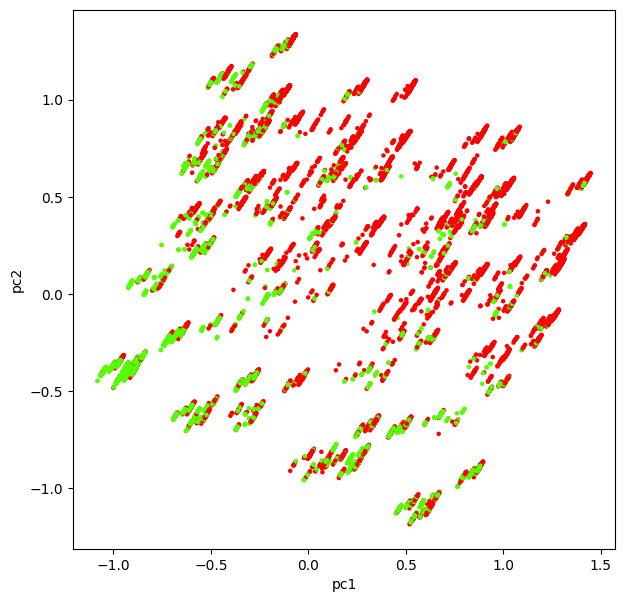

In [39]:
plt.figure(figsize=(7,7))
plt.scatter(df_pca_2['principal component 1'],df_pca_2['principal component 2'],c=df_pca_2['income'],cmap='prism', s =5)
plt.xlabel('pc1')
plt.ylabel('pc2')
plt.savefig('figs-sampled/pca.png')
plt.show()

In [40]:
pca = PCA()
df_pca = pca.fit_transform(x_train_scaled)

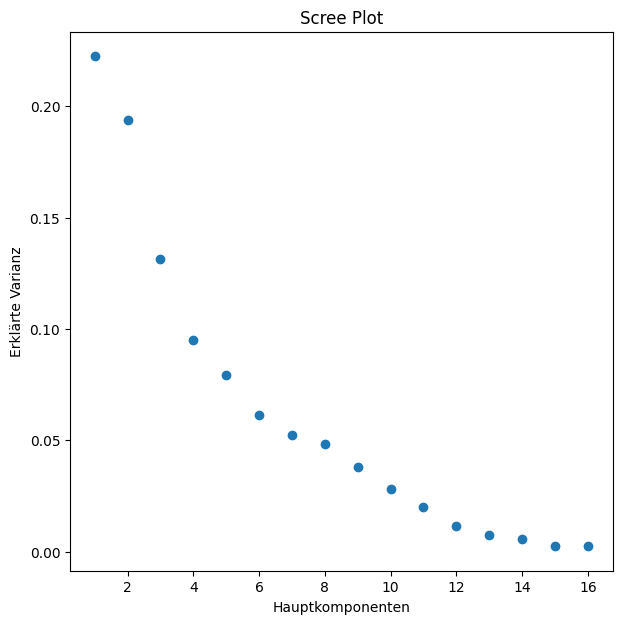

In [41]:
plt.figure(figsize=(7,7))
PC_values = np.arange(pca.n_components_) + 1
plt.scatter(PC_values, pca.explained_variance_ratio_)

plt.title('Scree Plot')
plt.xlabel('Hauptkomponenten')
plt.ylabel('Erklärte Varianz')
plt.savefig('figs-sampled/scree_plot.png')
plt.show()

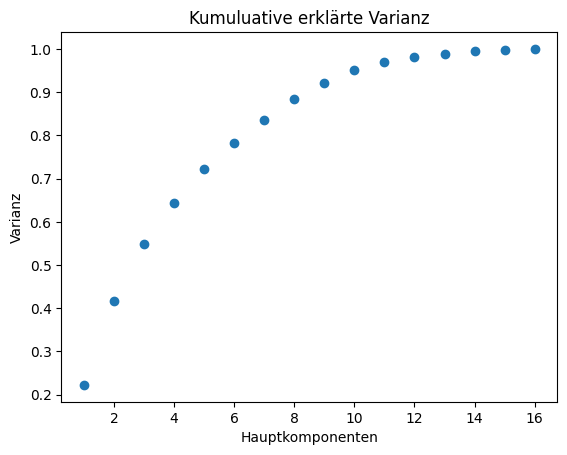

In [42]:
plt.xlabel('Hauptkomponenten')
plt.ylabel('Varianz')
plt.title('Kumuluative erklärte Varianz')
plt.scatter(PC_values, np.cumsum(pca.explained_variance_ratio_))
plt.savefig('figs-sampled/variance.png')
plt.show()

In [43]:
pca_8 = PCA(n_components=10)
df_pca_8 = pca_8.fit_transform(x_train_scaled)
df_pca_8_test = pca_8.transform(x_test_scaled)

df_pca_8 = pd.DataFrame(data=df_pca_8)
df_pca_8_test = pd.DataFrame(data=df_pca_8_test)

# Konstante 1er Spalte hinzufügen für Beta0
df_pca_8 = statsmodels.tools.add_constant(df_pca_8)
df_pca_8_test = statsmodels.tools.add_constant(df_pca_8_test)

## Clustering <a class="clustering" id="clustering"></a>

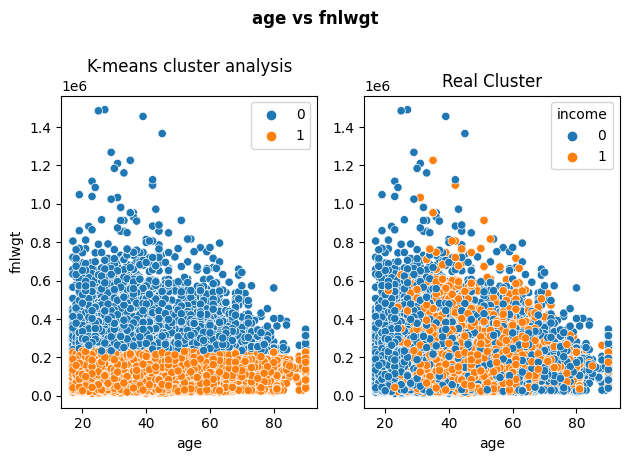

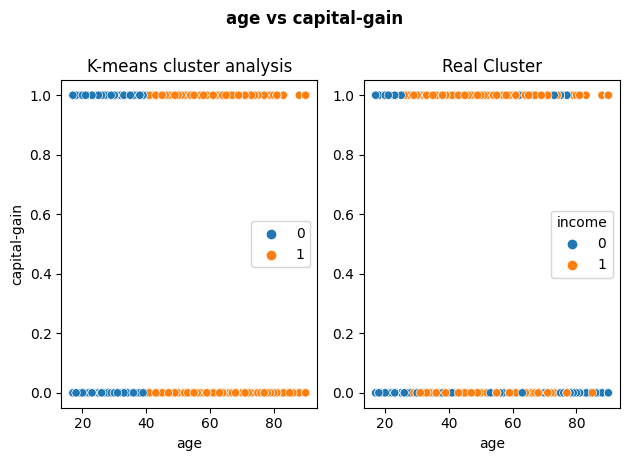

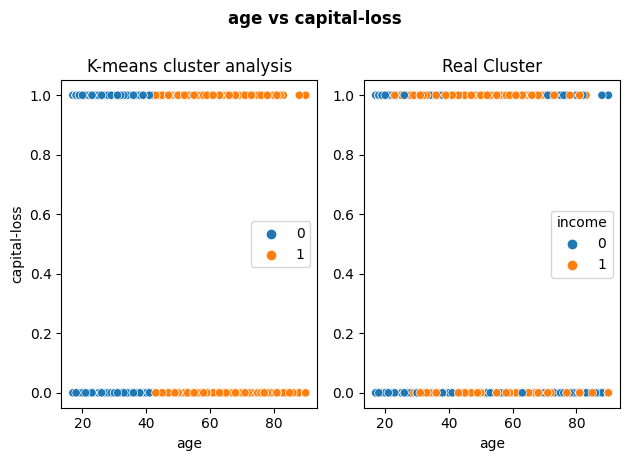

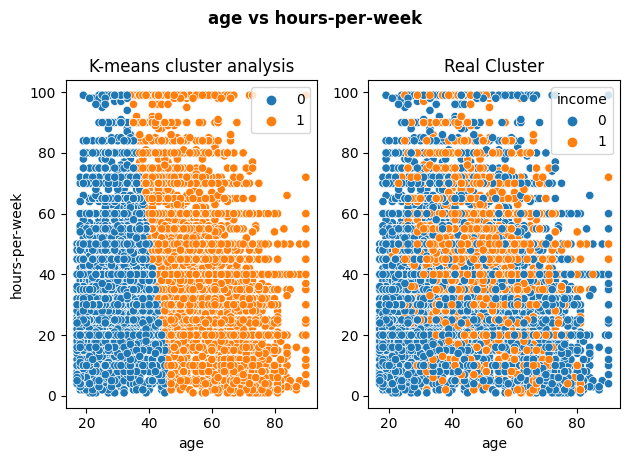

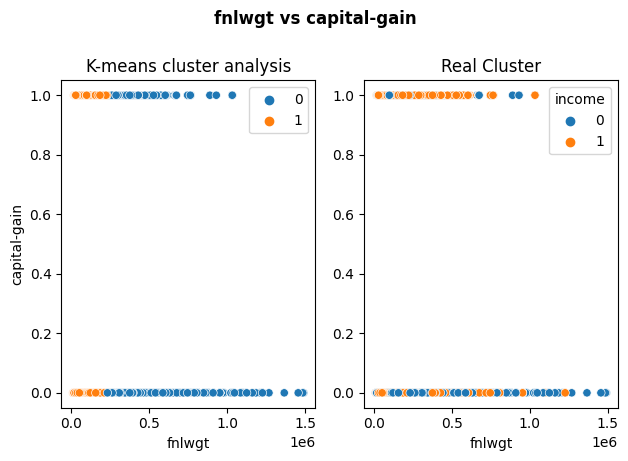

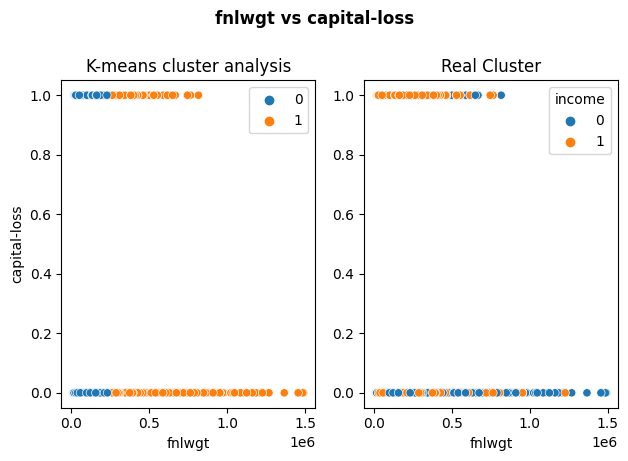

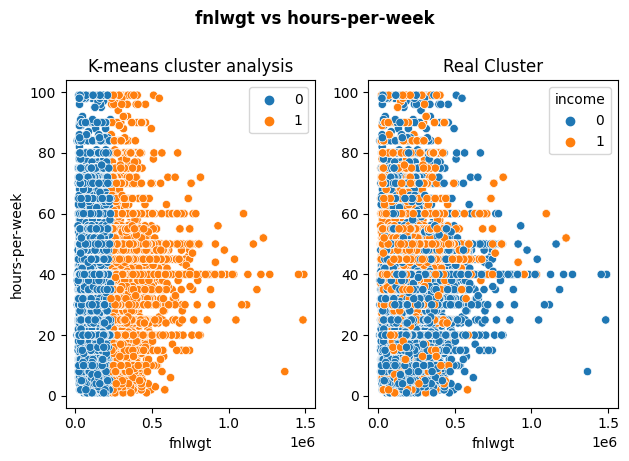

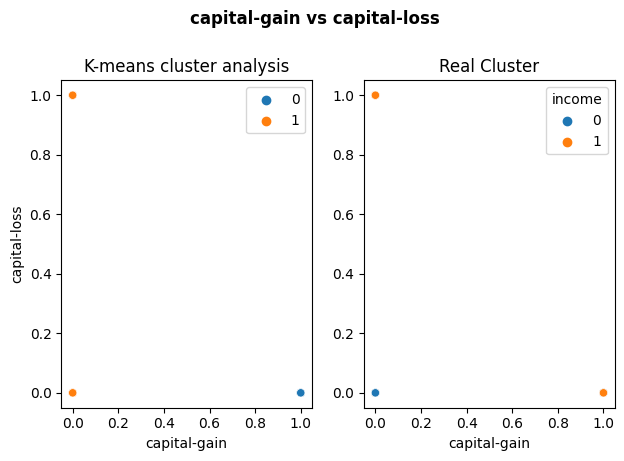

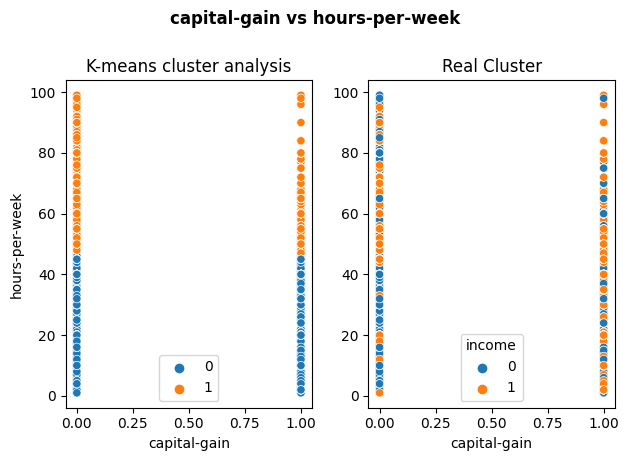

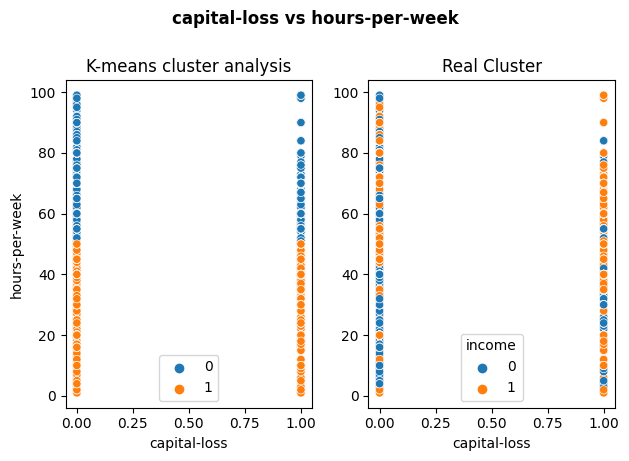

In [44]:
numeric_combinations = list(combinations(numeric, 2))

for combination in numeric_combinations:
    first = combination[0]
    second = combination[1]
    x = df[first]
    y = df[second]
    data = pd.concat([x, y], axis=1)

    kmeans = KMeans(n_clusters=2, random_state=None, n_init='auto')
    kmeans.fit(data)

    plt.subplot(1, 2, 1)
    sns.scatterplot(data=df, x=first, y=second, hue=kmeans.labels_)
    plt.xlabel(first)
    plt.ylabel(second)
    plt.title('K-means cluster analysis')

    plt.subplot(1, 2, 2, sharey=plt.gca())
    sns.scatterplot(data=df, x=first, y=second, hue='income')
    plt.xlabel(first)
    plt.ylabel('')
    plt.title('Real Cluster')

    plt.suptitle(f"{first} vs {second}", y=0.95, fontsize=12, fontweight='bold') 
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f'figs-sampled/{first}-{second}.png')
    plt.show()

# Modelle <a class="model" id="model"></a>

Konstante 1er Spale für Beta0 hinzufügen

In [45]:
x_train = statsmodels.tools.add_constant(x_train)
x_test = statsmodels.tools.add_constant(x_test)
x_train.head()

x_train_scaled = statsmodels.tools.add_constant(x_train_scaled)
x_test_scaled = statsmodels.tools.add_constant(x_test_scaled)
x_train_scaled.head()

const       age  workclass_1  workclass_2  workclass_3    fnlwgt  \
0    1.0  0.191781          1.0          0.0          0.0  0.146241   
1    1.0  0.164384          0.0          1.0          0.0  0.127688   
2    1.0  0.041096          0.0          1.0          0.0  0.119154   
3    1.0  0.178082          0.0          1.0          0.0  0.089153   
4    1.0  0.493151          0.0          1.0          0.0  0.092933   

   education_1  education_2  occupation_1  relationship_1  relationship_2  \
0          1.0          0.0           1.0             1.0             0.0   
1          1.0          0.0           0.0             0.0             1.0   
2          1.0          0.0           1.0             1.0             0.0   
3          0.0          1.0           0.0             0.0             1.0   
4          0.0          1.0           0.0             1.0             0.0   

   relationship_3  relationship_4  sex_1  capital-gain  capital-loss  \
0             0.0             0.0    1.0           0.0           0.0   
1             0.0             0.0    0.0           0.0           0.0   
2             0.0             0.0    1.0           0.0           0.0   
3             0.0             0.0    1.0           0.0           0.0   
4             0.0             0.0    1.0           0.0           1.0   

   hours-per-week  
0        0.397959  
1        0.500000  
2        0.602041  
3        0.622449  
4        0.479592

## Logit <a class="logit" id="logit"></a>

In [46]:
model = Logit(y_train_scaled, x_train_scaled).fit(method='newton')

Optimization terminated successfully.
         Current function value: 0.425112
         Iterations 7


In [47]:
model.mle_retvals

{'fopt': 0.4251120571759838,
 'iterations': 7,
 'score': array([-1.28272259e-17, -4.20348836e-18, -7.95231949e-18, -8.54463276e-18,
        -1.58448471e-18, -2.16734606e-18, -2.61888416e-17,  7.12083871e-18,
        -1.55458877e-18, -6.72658603e-20, -1.29524151e-17,  6.57710634e-19,
        -2.57665615e-18, -5.41303326e-18, -1.34531721e-18, -1.36960766e-18,
        -9.14702320e-18]),
 'Hessian': array([[-0.13681219, -0.046652  , -0.02135626, -0.09710206, -0.01284792,
         -0.01624983, -0.08474822, -0.04292862, -0.05834131, -0.03048077,
         -0.09155126, -0.00897808, -0.00417217, -0.1033056 , -0.01180613,
         -0.00765105, -0.05830269],
        [-0.046652  , -0.01958415, -0.00753025, -0.03183244, -0.00511693,
         -0.00541301, -0.02742011, -0.0152827 , -0.01979802, -0.00989512,
         -0.03238298, -0.00323365, -0.00067513, -0.0356481 , -0.00408605,
         -0.00262979, -0.0195297 ],
        [-0.02135626, -0.00753025, -0.02135626, -0.        , -0.        ,
         -0.

In [48]:
print(model.summary2())

                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: income           Pseudo R-squared: 0.387     
Date:               2023-06-23 08:10 AIC:              50552.6164
No. Observations:   59418            BIC:              50705.4864
Df Model:           16               Log-Likelihood:   -25259.   
Df Residuals:       59401            LL-Null:          -41185.   
Converged:          1.0000           LLR p-value:      0.0000    
No. Iterations:     7.0000           Scale:            1.0000    
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
const            -5.6964   0.1397 -40.7753 0.0000 -5.9702 -5.4226
age               2.1248   0.0723  29.3870 0.0000  1.9831  2.2665
workclass_1      -0.0049   0.0630  -0.0770 0.9386 -0.1284  0.1187
workclass_2      -0.2233   0.0578  -

In [49]:
y_predict = model.predict(x_test_scaled)

In [50]:
prediction = list(map(round, y_predict))
  
print('Actual values', list(y_test_scaled.values))
print('Predictions :', prediction)

Actual values [1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 

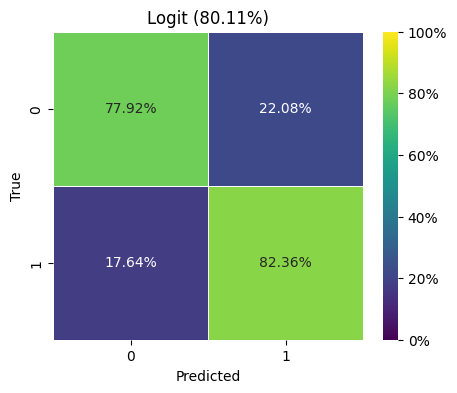

Test accuracy = 80.11 %


In [52]:
cm = confusion_matrix(y_test_scaled, prediction) 
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

accuracy = accuracy_score(y_test_scaled, prediction)

plt.figure(figsize=(5,4), dpi=100)
sns.heatmap(cmn, cmap="viridis", linewidth=0.5, fmt=".2%", annot=True, vmin=0, vmax=1)
formatter = mticker.FuncFormatter(lambda x, _: f"{x*100:.0f}%")
cax = plt.gcf().axes[-1]
cax.yaxis.set_major_formatter(formatter)
plt.title(f"Logit ({accuracy:.2%})")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('figs-sampled/logit-scaled.png')
plt.show()

print(f'Test accuracy = {accuracy_score(y_test_scaled, prediction).round(4)*100} %')

## Logit mit PCA <a class="logit-pca" id="logit-pca"></a>

In [53]:
model_pca = Logit(y_train_scaled, df_pca_8).fit(method='newton')

Optimization terminated successfully.
         Current function value: 0.446763
         Iterations 7


In [54]:
model_pca.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Method:           MLE       
Dependent Variable: income           Pseudo R-squared: 0.355     
Date:               2023-06-23 08:10 AIC:              53113.5784
No. Observations:   59418            BIC:              53212.4943
Df Model:           10               Log-Likelihood:   -26546.   
Df Residuals:       59407            LL-Null:          -41185.   
Converged:          1.0000           LLR p-value:      0.0000    
No. Iterations:     7.0000           Scale:            1.0000    
-------------------------------------------------------------------
         Coef.    Std.Err.       z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
const   -0.1099     0.0126     -8.7509   0.0000   -0.1345   -0.0853
0       -2.0464     0.0197   -103.8354   0.0000   -2.0850   -2.0078
1       -1.6241     0.0184    -88.2841   0.0000   -1.6601   -1.5880
2       -0.3230     0.0203    -15.8993   0.0000   -0.3628   -0.2832
3        0.7180     0.0244     29.4072   0.0000    0.6701    0.7658
4        0.9612     0.0322     29.8312   0.0000    0.8980    1.0243
5       -2.3893     0.0521    -45.8417   0.0000   -2.4915   -2.2871
6        0.5831     0.0402     14.5050   0.0000    0.5043    0.6618
7       -0.5632     0.0335    -16.8149   0.0000   -0.6288   -0.4975
8        0.2170     0.0470      4.6218   0.0000    0.1250    0.3091
9        1.4725     0.0487     30.2544   0.0000    1.3771    1.5679
=================================================================

"""

In [55]:
y_predict_scaled = model_pca.predict(df_pca_8_test)

In [56]:
prediction2 = list(map(round, y_predict_scaled))
  
# comparing original and predicted values of y
print('Actual values', list(y_test_scaled.values))
print('Predictions :', prediction2)

Actual values [1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 

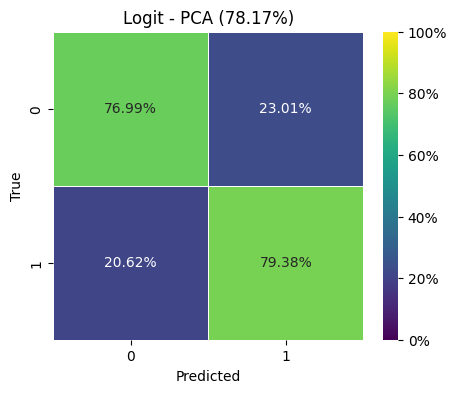

Test accuracy = 78.17 %


In [57]:
cm2 = confusion_matrix(y_test_scaled, prediction2) 
cmn2 = cm2.astype('float') / cm2.sum(axis=1)[:, np.newaxis]

accuracy = accuracy_score(y_test_scaled, prediction2)

plt.figure(figsize=(5,4), dpi=100)
sns.heatmap(cmn2, cmap="viridis", linewidth=0.5, fmt=".2%", annot=True, vmin=0, vmax=1)
formatter = mticker.FuncFormatter(lambda x, _: f"{x*100:.0f}%")
cax = plt.gcf().axes[-1]
cax.yaxis.set_major_formatter(formatter)
plt.title(f"Logit - PCA ({accuracy:.2%})")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('figs-sampled/logit-pca.png')
plt.show()
  
# accuracy score of the model
print(f'Test accuracy = {accuracy_score(y_test_scaled, prediction2).round(4)*100} %')

## Logit mit nicht lineaer transformierten Daten <a class="logit-transformed" id="logit-transformed"></a>

In [58]:
logit_x_train_scaled = x_train_scaled
logit_x_train_scaled['age'] = np.log(logit_x_train_scaled['age'] + 1)
logit_x_train_scaled['fnlwgt'] = np.log(logit_x_train_scaled['fnlwgt'] + 1)

logit_x_test_scaled = x_test_scaled
logit_x_test_scaled['age'] = np.log(logit_x_test_scaled['age'] + 1)
logit_x_test_scaled['fnlwgt'] = np.log(logit_x_test_scaled['fnlwgt'] + 1)

In [59]:
model_transformed = Logit(y_train_scaled, logit_x_train_scaled).fit(method='newton')

Optimization terminated successfully.
         Current function value: 0.423684
         Iterations 7


In [60]:
model_transformed.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Method:           MLE       
Dependent Variable: income           Pseudo R-squared: 0.389     
Date:               2023-06-23 08:11 AIC:              50382.9288
No. Observations:   59418            BIC:              50535.7988
Df Model:           16               Log-Likelihood:   -25174.   
Df Residuals:       59401            LL-Null:          -41185.   
Converged:          1.0000           LLR p-value:      0.0000    
No. Iterations:     7.0000           Scale:            1.0000    
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
const            -5.8787   0.1411 -41.6686 0.0000 -6.1553 -5.6022
age               3.1646   0.0990  31.9776 0.0000  2.9706  3.3586
workclass_1      -0.0031   0.0631  -0.0491 0.9608 -0.1268  0.1206
workclass_2      -0.2107   0.0578  -3.6457 0.0003 -0.3240 -0.0974
workclass_3      -0.5936   0.0664  -8.9431 0.0000 -0.7238 -0.4635
fnlwgt            1.1338   0.1840   6.1637 0.0000  0.7733  1.4944
education_1       2.2002   0.0472  46.6606 0.0000  2.1078  2.2926
education_2       1.2341   0.0477  25.8548 0.0000  1.1406  1.3277
occupation_1     -0.6112   0.0243 -25.1385 0.0000 -0.6589 -0.5636
relationship_1    0.3892   0.1048   3.7131 0.0002  0.1838  0.5947
relationship_2    2.5434   0.1035  24.5758 0.0000  2.3406  2.7463
relationship_3    0.0957   0.1113   0.8601 0.3897 -0.1224  0.3138
relationship_4   -0.7236   0.1206  -5.9984 0.0000 -0.9600 -0.4871
sex_1             0.1906   0.0294   6.4756 0.0000  0.1329  0.2482
capital-gain      1.8696   0.0402  46.5497 0.0000  1.7909  1.9483
capital-loss      1.1932   0.0486  24.5700 0.0000  1.0980  1.2884
hours-per-week    3.6554   0.1025  35.6560 0.0000  3.4545  3.8564
=================================================================

"""

In [61]:
y_predict_transformed = model_transformed.predict(logit_x_test_scaled)
prediction_transformed = list(map(round, y_predict_transformed))
  
print('Actual values', list(y_test_scaled.values))
print('Predictions :', prediction_transformed)

Actual values [1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 

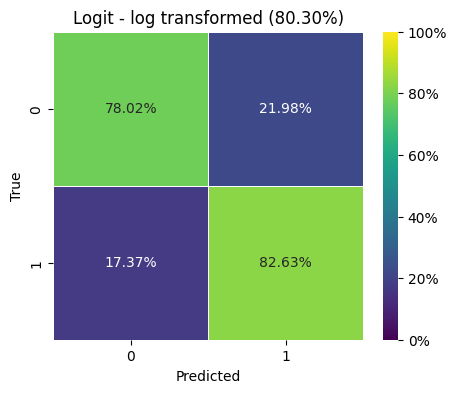

Test accuracy = 80.30% %


In [62]:
cm3 = confusion_matrix(y_test_scaled, prediction_transformed) 
cmn3 = cm3.astype('float') / cm3.sum(axis=1)[:, np.newaxis]

accuracy = accuracy_score(y_test_scaled, prediction_transformed)

plt.figure(figsize=(5,4), dpi=100)
sns.heatmap(cmn3, cmap="viridis", linewidth=0.5, fmt=".2%", annot=True, vmin=0, vmax=1)
formatter = mticker.FuncFormatter(lambda x, _: f"{x*100:.0f}%")
cax = plt.gcf().axes[-1]
cax.yaxis.set_major_formatter(formatter)
plt.title(f"Logit - log transformed ({accuracy:.2%})")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('figs-sampled/logit-log-transformed.png')
plt.show()
  
print(f'Test accuracy = {accuracy:.2%} %')

Droppen der konstanten 1er Spalte für Beta0

In [63]:
df_pca_8 = df_pca_8.drop("const", axis=1)
df_pca_8_test = df_pca_8_test.drop("const", axis=1)

x_train = x_train.drop("const", axis=1)
x_test = x_test.drop("const", axis=1)

x_train_scaled = x_train_scaled.drop("const", axis=1)
x_test_scaled = x_test_scaled.drop("const", axis=1)

## Random Forest <a class="random-forest" id="random-forest"></a>

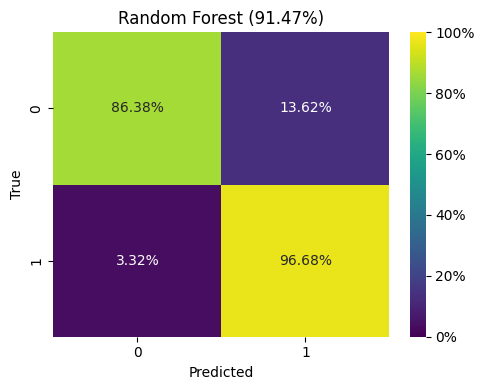

In [78]:
forest = RandomForestClassifier(n_estimators=50)
forest.fit(x_train_scaled, y_train_scaled)

y_predict = forest.predict(x_test_scaled)
 
forest_score_accuracy = forest.score(x_test_scaled, y_test_scaled)

cm_forest = confusion_matrix(y_test_scaled, y_predict)
cm_forest_normalized = cm_forest.astype('float') / cm_forest.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(5,4), dpi=100)

sns.heatmap(cm_forest_normalized, cmap='viridis', annot=True, fmt=".2%", vmin=0, vmax=1)
plt.title(f'Random Forest ({forest_score_accuracy:.2%})')
plt.xlabel('Predicted')
plt.ylabel('True')

formatter = mticker.FuncFormatter(lambda x, _: f"{x*100:.0f}%")
cax = plt.gcf().axes[-1]
cax.yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.savefig('figs-sampled/random-forest.png')

plt.show()

## Random Forest tuned <a class="random-forest-tuned" id="random-forest-tuned"></a>

In [65]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [100, 110, 120, 130, 140],
    'max_features': [2, 3, 4, 5],
    'min_samples_leaf': [5, 6, 7, 8],
    'min_samples_split': [12, 14, 16, 18],
    'n_estimators': [30, 40, 45, 50, 60]
}

In [66]:
forest_tuned = RandomForestClassifier()

grid_search = GridSearchCV(estimator=forest_tuned, param_grid=param_grid, cv=3, n_jobs=-1)

grid_search.fit(x_train_scaled, y_train_scaled)

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True],
                         'max_depth': [100, 110, 120, 130, 140],
                         'max_features': [2, 3, 4, 5],
                         'min_samples_leaf': [5, 6, 7, 8],
                         'min_samples_split': [12, 14, 16, 18],
                         'n_estimators': [30, 40, 45, 50, 60]})

In [67]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 140,
 'max_features': 5,
 'min_samples_leaf': 5,
 'min_samples_split': 12,
 'n_estimators': 50}

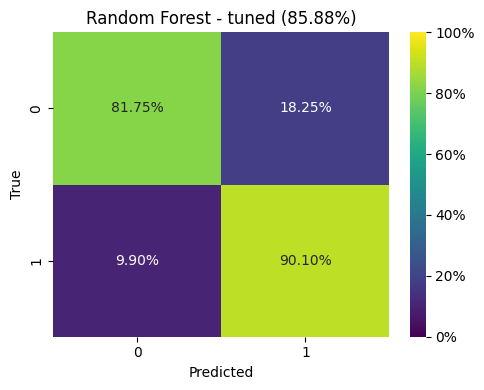

In [68]:
forest_tuned_new = RandomForestClassifier(**grid_search.best_params_)

forest_tuned_new.fit(x_train_scaled, y_train_scaled)

y_predict = forest_tuned_new.predict(x_test_scaled)
 
forest_score_accuracy = forest_tuned_new.score(x_test_scaled, y_test_scaled)

cm_forest = confusion_matrix(y_test_scaled, y_predict)
cm_forest_normalized = cm_forest.astype('float') / cm_forest.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(5,4), dpi=100)

sns.heatmap(cm_forest_normalized, annot=True, fmt=".2%", cmap='viridis', vmin=0, vmax=1)
plt.title(f'Random Forest - tuned ({forest_score_accuracy:.2%})')
plt.xlabel('Predicted')
plt.ylabel('True')

formatter = mticker.FuncFormatter(lambda x, _: f"{x*100:.0f}%")
cax = plt.gcf().axes[-1]
cax.yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.savefig('figs-sampled/random-tuned.png')

plt.show()

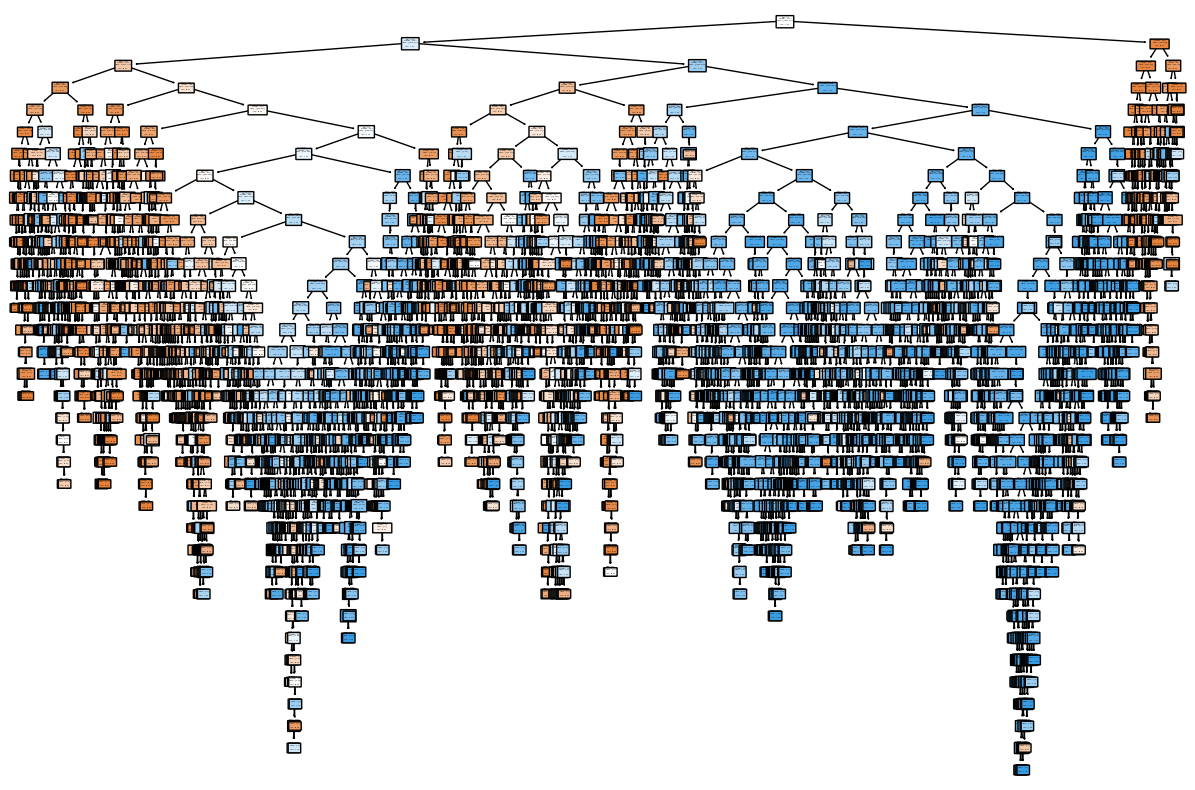

In [69]:
fig = plt.figure(figsize=(15, 10))
plot_tree(forest_tuned_new.estimators_[0], 
    feature_names=x_train_scaled.columns,
    class_names=['$\leq50$k', '$>50$k'], 
    filled=True, impurity=True, 
    rounded=True)
fig.savefig('figs-sampled/random_forest_tuned_model.png')

## Random Forest mit PCA <a class="random-forest-pca" id="random-forest-pca"></a>

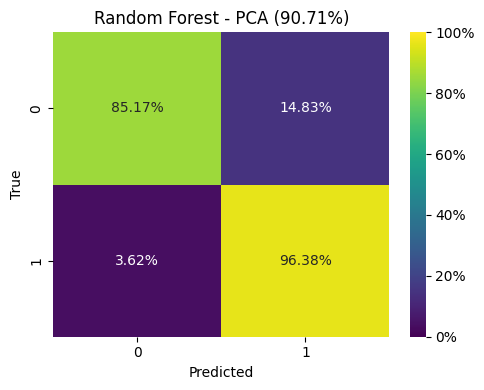

In [70]:
forest = RandomForestClassifier(n_estimators=50)
forest.fit(df_pca_8, y_train_scaled)

y_predict = forest.predict(df_pca_8_test)
 
forest_score_accuracy = forest.score(df_pca_8_test, y_test_scaled)

cm_forest = confusion_matrix(y_test_scaled, y_predict)
cm_forest_normalized = cm_forest.astype('float') / cm_forest.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(5,4), dpi=100)

sns.heatmap(cm_forest_normalized, cmap='viridis', annot=True, fmt=".2%", vmin=0, vmax=1)
plt.title(f'Random Forest - PCA ({forest_score_accuracy:.2%})')
plt.xlabel('Predicted')
plt.ylabel('True')

formatter = mticker.FuncFormatter(lambda x, _: f"{x*100:.0f}%")
cax = plt.gcf().axes[-1]
cax.yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.savefig('figs-sampled/random-forest-pca.png')

plt.show()

## Neuronales Netz <a class="neuronal" id="neuronal"></a>

In [79]:
epochs = 250

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=16, activation='relu'))
model.add(tf.keras.layers.Dense(units=8, activation='relu'))
model.add(tf.keras.layers.Dense(units=2, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(x_train_scaled, y_train_scaled, validation_split=0.1, batch_size=16, epochs=epochs, callbacks=[stop_early])

Epoch 1/250
3343/3343 [==============================] - 2s 556us/step - loss: 0.4441 - accuracy: 0.7896 - val_loss: 0.4276 - val_accuracy: 0.7938
Epoch 2/250
3343/3343 [==============================] - 2s 521us/step - loss: 0.4178 - accuracy: 0.8044 - val_loss: 0.4209 - val_accuracy: 0.8034
Epoch 3/250
3343/3343 [==============================] - 2s 575us/step - loss: 0.4127 - accuracy: 0.8083 - val_loss: 0.4168 - val_accuracy: 0.8051
Epoch 4/250
3343/3343 [==============================] - 2s 530us/step - loss: 0.4092 - accuracy: 0.8108 - val_loss: 0.4162 - val_accuracy: 0.8088
Epoch 5/250
3343/3343 [==============================] - 3s 821us/step - loss: 0.4071 - accuracy: 0.8118 - val_loss: 0.4118 - val_accuracy: 0.8081
Epoch 6/250
3343/3343 [==============================] - 2s 592us/step - loss: 0.4055 - accuracy: 0.8122 - val_loss: 0.4125 - val_accuracy: 0.8110
Epoch 7/250
3343/3343 [==============================] - 2s 550us/step - loss: 0.4046 - accuracy: 0.8129 - val_loss: 0

In [80]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 2)                 18        
                                                                 
 dense_3 (Dense)             (None, 1)                 3         
                                                                 
Total params: 429 (1.68 KB)
Trainable params: 429 (1.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


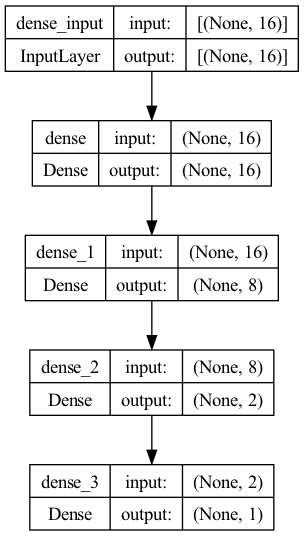

In [81]:
tf.keras.utils.plot_model(model, to_file='figs-sampled/nn_model_plot.png', show_shapes=True, show_layer_names=True)

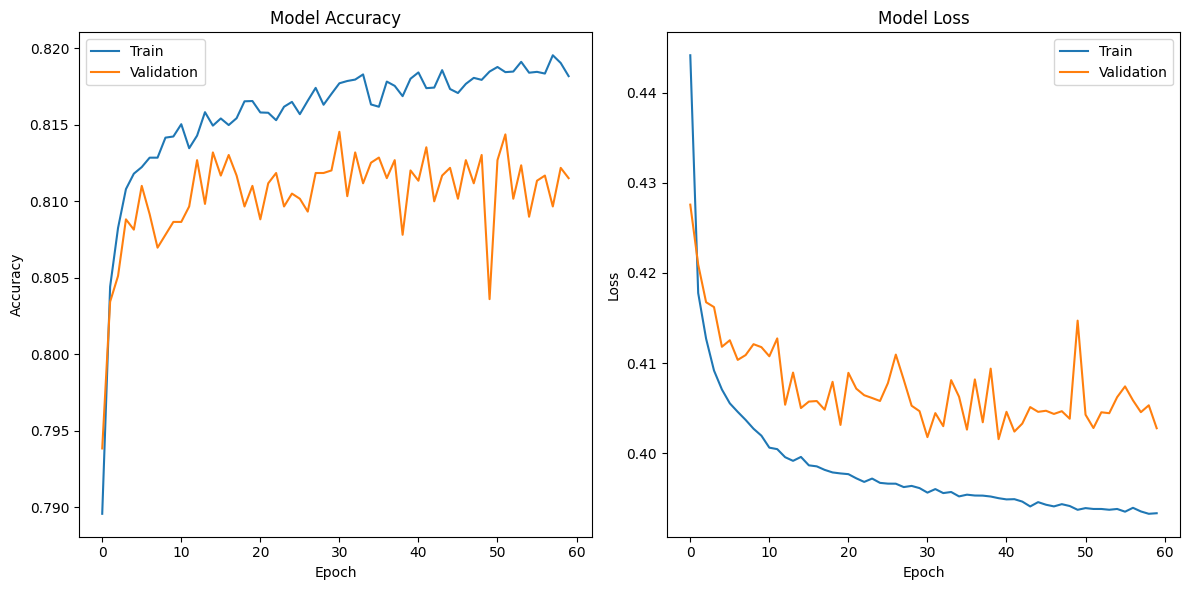

In [82]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].set_title('Model Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Validation'], loc='upper left')

axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('Model Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.savefig('figs-sampled/nn_accuracy_loss.png')

plt.show()

465/465 [==============================] - 0s 359us/step


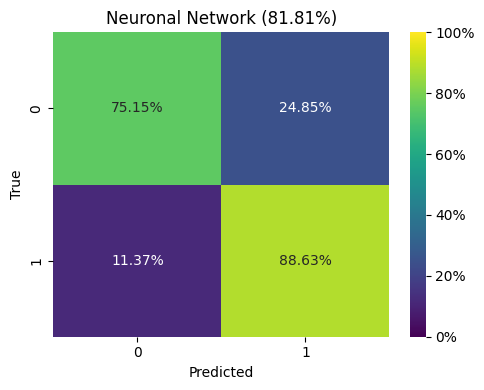

In [83]:
y_pred_prob = model.predict(x_test_scaled)
y_pred = np.round(y_pred_prob).flatten()

cm_nn = confusion_matrix(y_test_scaled, y_pred)
cm_nn_normalized = cm_nn.astype('float') / cm_nn.sum(axis=1)[:, np.newaxis]
nn_accuracy = accuracy_score(y_test_scaled, y_pred)

plt.figure(figsize=(5,4), dpi=100)

sns.heatmap(cm_nn_normalized, annot=True, fmt=".2%", cmap='viridis', vmin=0, vmax=1)
plt.title(f'Neuronal Network ({nn_accuracy:.2%})')
plt.xlabel('Predicted')
plt.ylabel('True')

formatter = mticker.FuncFormatter(lambda x, _: f"{x*100:.0f}%")
cax = plt.gcf().axes[-1]
cax.yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.savefig('figs-sampled/nn_confusion_matrix.png')

plt.show()

## Neuronales Netz mit PCA <a class="neuronal-pca" id="neuronal-pca"></a>

In [84]:
epochs = 250

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=10, activation='relu'))
model.add(tf.keras.layers.Dense(units=5, activation='relu'))
model.add(tf.keras.layers.Dense(units=2, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

history = model.fit(df_pca_8, y_train_scaled, validation_split=0.1, batch_size=8, epochs=epochs, callbacks=[stop_early])

Epoch 1/250
6685/6685 [==============================] - 4s 593us/step - loss: 0.4798 - accuracy: 0.7766 - val_loss: 0.4562 - val_accuracy: 0.7910
Epoch 2/250
6685/6685 [==============================] - 4s 606us/step - loss: 0.4416 - accuracy: 0.7951 - val_loss: 0.4467 - val_accuracy: 0.7964
Epoch 3/250
6685/6685 [==============================] - 4s 533us/step - loss: 0.4351 - accuracy: 0.7990 - val_loss: 0.4420 - val_accuracy: 0.7974
Epoch 4/250
6685/6685 [==============================] - 4s 562us/step - loss: 0.4305 - accuracy: 0.8006 - val_loss: 0.4378 - val_accuracy: 0.8004
Epoch 5/250
6685/6685 [==============================] - 4s 603us/step - loss: 0.4284 - accuracy: 0.8020 - val_loss: 0.4363 - val_accuracy: 0.8006
Epoch 6/250
6685/6685 [==============================] - 4s 530us/step - loss: 0.4273 - accuracy: 0.8030 - val_loss: 0.4365 - val_accuracy: 0.8016
Epoch 7/250
6685/6685 [==============================] - 4s 568us/step - loss: 0.4260 - accuracy: 0.8031 - val_loss: 0

In [85]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 10)                110       
                                                                 
 dense_5 (Dense)             (None, 5)                 55        
                                                                 
 dense_6 (Dense)             (None, 2)                 12        
                                                                 
 dense_7 (Dense)             (None, 1)                 3         
                                                                 
Total params: 180 (720.00 Byte)
Trainable params: 180 (720.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


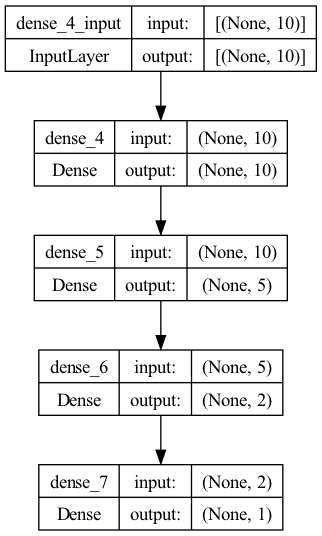

In [86]:
tf.keras.utils.plot_model(model, to_file='figs-sampled/nn_model_pca_plot.png', show_shapes=True, show_layer_names=True)

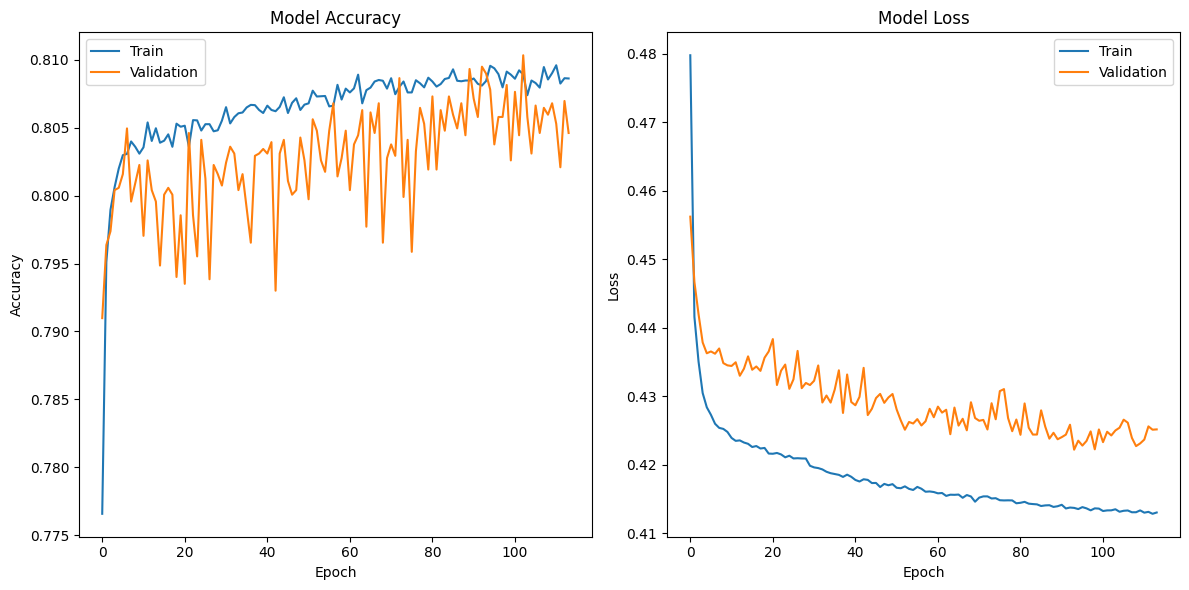

In [87]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].set_title('Model Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Validation'], loc='upper left')

axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('Model Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.savefig('figs-sampled/nn_pca_accuracy_loss.png')

plt.show()

465/465 [==============================] - 0s 422us/step


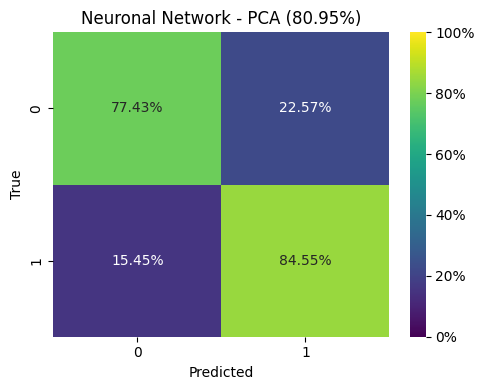

In [88]:
y_pred_prob = model.predict(df_pca_8_test)
y_pred = np.round(y_pred_prob).flatten()

cm_nn = confusion_matrix(y_test_scaled, y_pred)
cm_nn_normalized = cm_nn.astype('float') / cm_nn.sum(axis=1)[:, np.newaxis]
nn_accuracy = accuracy_score(y_test_scaled, y_pred)

plt.figure(figsize=(5,4), dpi=100)

sns.heatmap(cm_nn_normalized, annot=True, fmt=".2%", cmap='viridis', vmin=0, vmax=1)
plt.title(f'Neuronal Network - PCA ({nn_accuracy:.2%})')
plt.xlabel('Predicted')
plt.ylabel('True')

formatter = mticker.FuncFormatter(lambda x, _: f"{x*100:.0f}%")
cax = plt.gcf().axes[-1]
cax.yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.savefig('figs-sampled/nn_pca_confusion_matrix.png')

plt.show()

## Vergleich der Modelle <a class="compare" id="compare"></a>

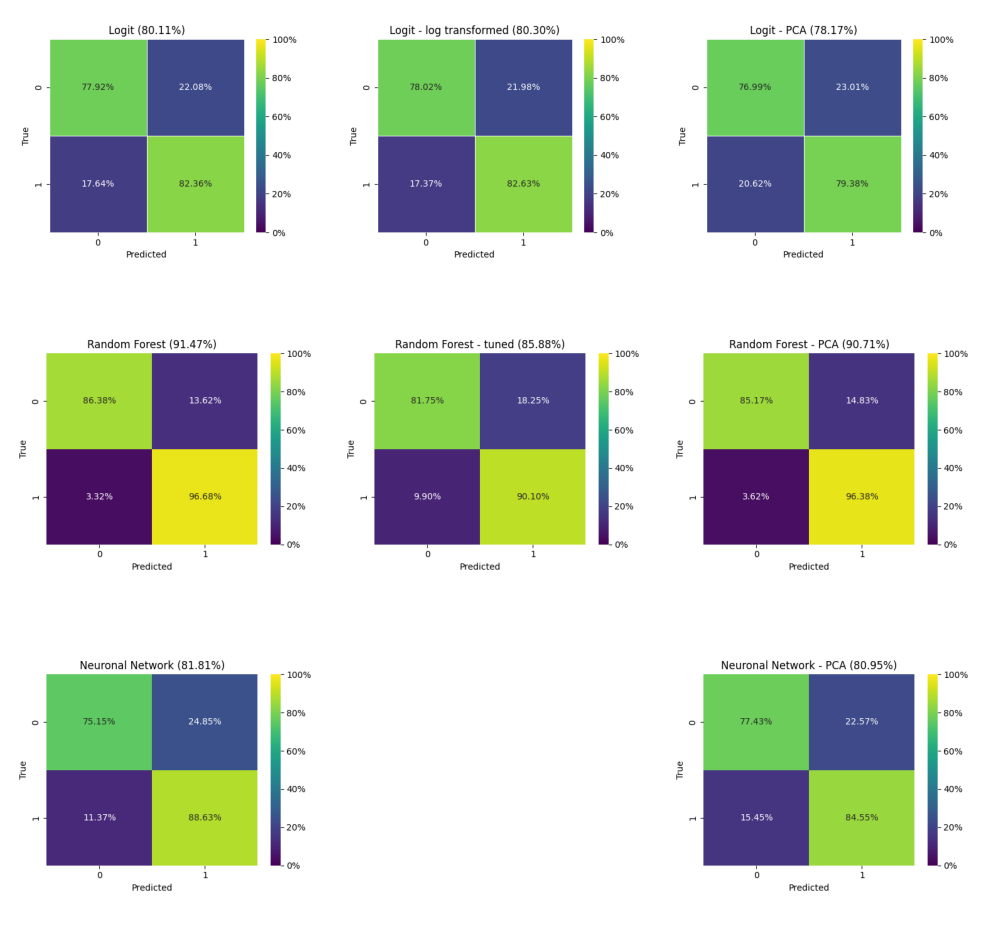

In [90]:
l1 = mpimg.imread('figs-sampled/logit-scaled.png')
l2 = mpimg.imread('figs-sampled/logit-log-transformed.png')
l3 = mpimg.imread('figs-sampled/logit-pca.png')
 
r1 = mpimg.imread('figs-sampled/random-forest.png')
r2 = mpimg.imread('figs-sampled/random-tuned.png')
r3 = mpimg.imread('figs-sampled/random-forest-pca.png')

n1 = mpimg.imread('figs-sampled/nn_confusion_matrix.png')
n3 = mpimg.imread('figs-sampled/nn_pca_confusion_matrix.png')

fig, axs = plt.subplots(3, 3, figsize=(10, 10))

axs[0, 0].imshow(l1)
axs[0, 0].axis('off')

axs[0, 1].imshow(l2)
axs[0, 1].axis('off')

axs[0, 2].imshow(l3)
axs[0, 2].axis('off')

axs[1, 0].imshow(r1)
axs[1, 0].axis('off')

axs[1, 1].imshow(r2)
axs[1, 1].axis('off')

axs[1, 2].imshow(r3)
axs[1, 2].axis('off')

axs[2, 0].imshow(n1)
axs[2, 0].axis('off')

axs[2, 1].axis('off')

axs[2, 2].imshow(n3)
axs[2, 2].axis('off')

plt.tight_layout()
plt.savefig('figs-sampled/model-compare.png')
plt.show()